In [6]:
import numpy as np
import pandas as pd        
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# from collections import Counter
# from wordcloud import WordCloud

# from IPython.display import display, HTML

np.set_printoptions(suppress=True)

In [5]:
df_train = pd.read_csv('../../../../data/train.csv')
df_test = pd.read_csv('../../../../data/test.csv')

/tmp/ipykernel_178464/3946945178.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../../../../data/train.csv')


In [7]:
def visualize_samples(df, feature_name):
    value_counts = df[feature_name].value_counts()

    top_n = 30

    plt.figure(figsize=(10, 5))
    value_counts.head(top_n).plot(kind='bar', color='skyblue')

    plt.title(f'{feature_name} Top {top_n} Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.xticks(rotation=75, ha='right')
    plt.show()

def print_samples(df, feature_name, show_graph):
    value_counts = df[feature_name].value_counts()
    unique_count = df[feature_name].nunique()


    print_n = 10
    if unique_count <= print_n:
        total_count = value_counts.sum()

        for value, count in value_counts.items():
            percent = (count / total_count) * 100
            print(f"{str(value).ljust(15)} : {count:,}, ({percent:.2f}%)")
    else:
        head_n_values = value_counts.head(print_n // 2)
        tail_n_values = value_counts.tail(print_n // 2)

        head_n_dict = head_n_values.to_dict()
        tail_n_dict = tail_n_values.to_dict()

        total_count = value_counts.sum()

        for word, count in head_n_dict.items():
            percent = (count / total_count) * 100
            print(f"{str(word).ljust(15)} : {count:,}, ({percent:.2f}%)")
        print('...')
        for word, count in tail_n_dict.items():
            percent = (count / total_count) * 100
            print(f"{str(word).ljust(15)} : {count:,}, ({percent:.2f}%)")


    if show_graph == True:
        print(f"{'-'*20} Visualize Samples {'-'*20}")

        visualize_samples(df, feature_name)

def feature_summary(df, feature_name, custom_missing_value, show_graph):
    print(" " * 50)
    print("=" * 50)
    print(f"[ {feature_name} ]")
    print(" " * 50)
    print(f"{'-'*20} Statistics Values {'-'*20}")  

    missing_value_num = ((df[feature_name] == "") | (df[feature_name] == " ")).sum()
    missing_value_num += df[feature_name].apply(lambda x: isinstance(x, float) and pd.isna(x)).sum()
    missing_value_num += df[feature_name].apply(lambda x: x is pd.NA).sum()
    missing_value_num += df[feature_name].apply(lambda x: x is None).sum()
    
    for missing_value in custom_missing_value:
        missing_value_num += (df[feature_name] == missing_value).sum()

    print(f"Unique          : {df[feature_name].nunique()}")
    print(f"Unique (%)      : {(df[feature_name].nunique() / df[feature_name].shape[0]) * 100:.2f}%")
    print(f'Missing         : {missing_value_num}')
    print(f'Missing (%)     : {(missing_value_num / df[feature_name].shape[0]) * 100:.2f}%')
    print(f'Memory size     : {df[feature_name].memory_usage(deep=True) / (1024 ** 2):.2f} MB')

    print(" " * 50)

    print(f"[ More Details ]")  
    
    print(f"{'-'*20} Missing Values {'-'*20}")  

    print("np.nan :", (df[feature_name].apply(lambda x: isinstance(x, float) and pd.isna(x))).sum())
    print("pd.NA :", (df[feature_name].apply(lambda x: x is pd.NA)).sum())
    print("None :", (df[feature_name].apply(lambda x: x is None)).sum())
    print('Empty or Whitespace :', ((df[feature_name] == "") | (df[feature_name] == " ")).sum())

    for missing_value in custom_missing_value:
        print(f'{missing_value} :', (df[feature_name] == missing_value).sum())

    if pd.api.types.is_numeric_dtype(df[feature_name]):
        print(f"{'-'*20} Samples {'-'*20}") 
        print_samples(df, feature_name, show_graph)
    else:
        # print(f"{'-'*20} Words {'-'*20}") 
        # print_words(df, feature_name)
        print(f"{'-'*20} Samples {'-'*20}") 
        print_samples(df, feature_name, show_graph)

    print("=" * 50)
    print(" " * 50)

                                                  
[ 시군구 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 339
Unique (%)      : 0.03%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 154.62 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
서울특별시 노원구 상계동   : 44,948, (4.02%)
서울특별시 노원구 중계동   : 26,357, (2.36%)
서울특별시 양천구 신정동   : 23,569, (2.11%)
서울특별시 도봉구 창동    : 23,101, (2.06%)
서울특별시 구로구 구로동   : 22,811, (2.04%)
...
서울특별시 종로구 신문로2가 : 6, (0.00%)
서울특별시 용산구 주성동   : 5, (0.00%)
서울특별시 종로구 연지동   : 4, (0.00%)
서울특별시 마포구 구수동   : 3, (0.00%)
서울특별시 중구 입정동    : 1, (0.00%)
-------------------- Visualize Samples --------------------


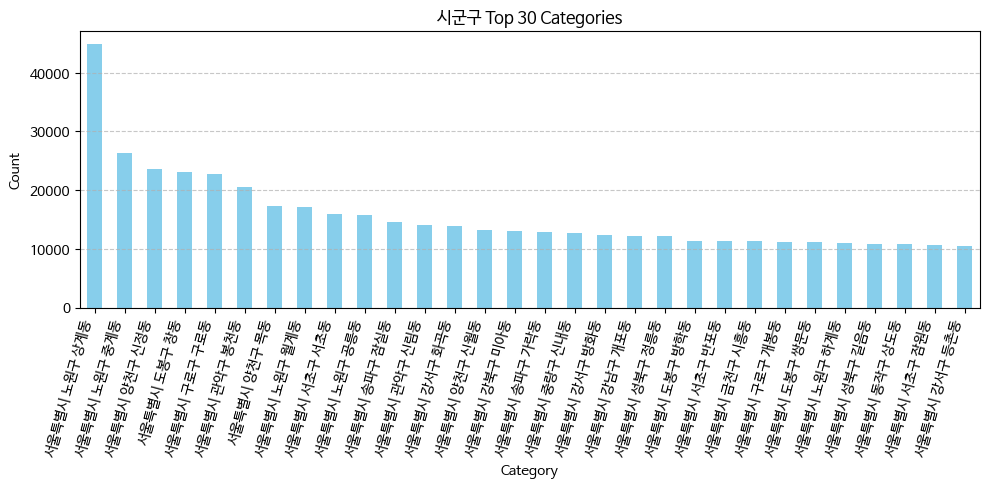

                                                  
                                                  
[ 번지 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 6572
Unique (%)      : 0.59%
Missing         : 225
Missing (%)     : 0.02%
Memory size     : 64.68 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 225
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
13              : 4,629, (0.41%)
17              : 4,548, (0.41%)
10              : 4,531, (0.41%)
347             : 4,264, (0.38%)
105             : 4,158, (0.37%)
...
539-5           : 1, (0.00%)
752-42          : 1, (0.00%)
3-1507          : 1, (0.00%)
1553-15         : 1, (0.00%)
792-108         : 1, (0.00%)
-------------------- Visualize Samples --------------------


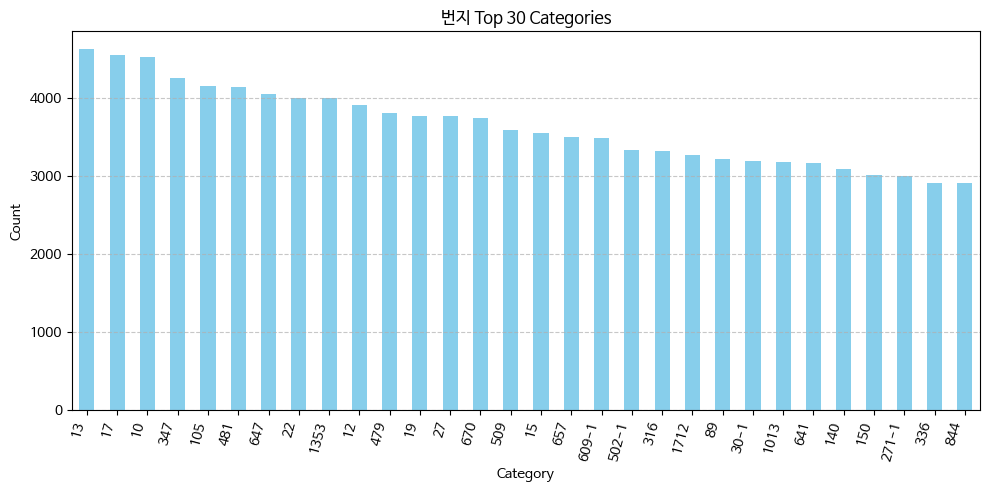

                                                  
                                                  
[ 본번 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 1523
Unique (%)      : 0.14%
Missing         : 75
Missing (%)     : 0.01%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 75
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
30.0            : 7,035, (0.63%)
17.0            : 5,485, (0.49%)
13.0            : 5,238, (0.47%)
271.0           : 4,983, (0.45%)
1.0             : 4,947, (0.44%)
...
2015.0          : 2, (0.00%)
1200.0          : 2, (0.00%)
4974.0          : 1, (0.00%)
1486.0          : 1, (0.00%)
2039.0          : 1, (0.00%)
-------------------- Visualize Samples --------------------


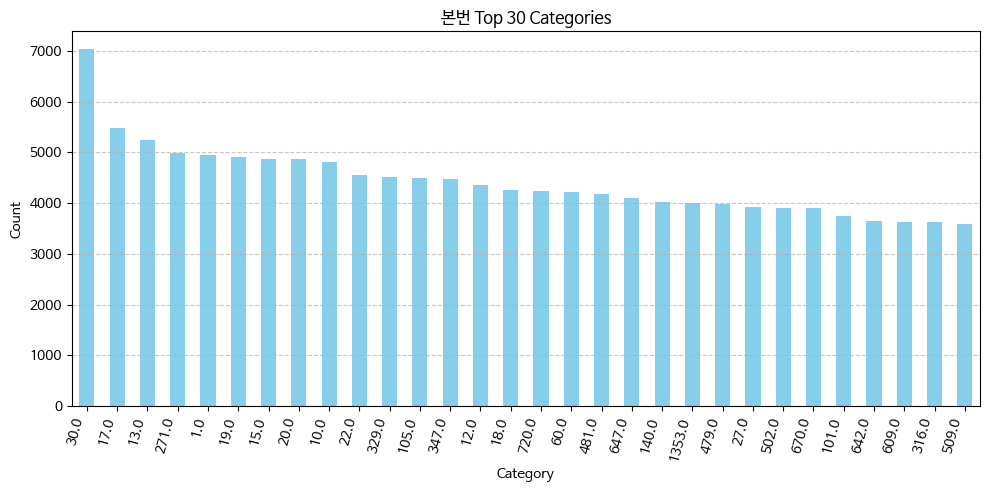

                                                  
                                                  
[ 부번 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 329
Unique (%)      : 0.03%
Missing         : 75
Missing (%)     : 0.01%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 75
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
0.0             : 819,792, (73.28%)
1.0             : 94,949, (8.49%)
2.0             : 27,815, (2.49%)
3.0             : 17,983, (1.61%)
5.0             : 13,946, (1.25%)
...
366.0           : 2, (0.00%)
340.0           : 2, (0.00%)
1507.0          : 1, (0.00%)
516.0           : 1, (0.00%)
233.0           : 1, (0.00%)
-------------------- Visualize Samples --------------------


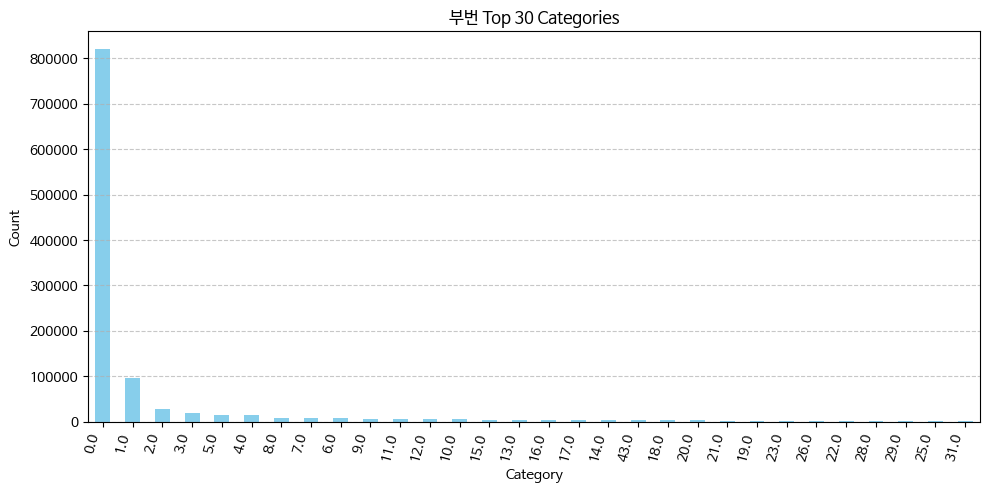

                                                  
                                                  
[ 아파트명 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 6538
Unique (%)      : 0.58%
Missing         : 2126
Missing (%)     : 0.19%
Memory size     : 98.53 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 2126
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
현대              : 16,644, (1.49%)
신동아             : 12,846, (1.15%)
한신              : 9,074, (0.81%)
두산              : 8,533, (0.76%)
주공2             : 7,918, (0.71%)
...
연세리버빌7차B동       : 1, (0.00%)
서울시니어스가양타워      : 1, (0.00%)
807-39          : 1, (0.00%)
밀란체             : 1, (0.00%)
신용산빌딩           : 1, (0.00%)
-------------------- Visualize Samples --------------------


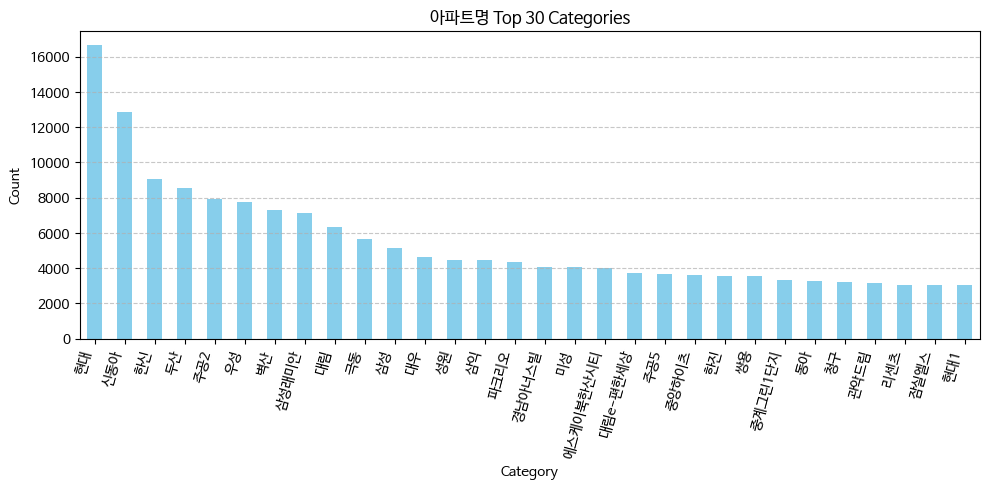

                                                  
                                                  
[ 전용면적(㎡) ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 14617
Unique (%)      : 1.31%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
84.96           : 20,420, (1.83%)
84.97           : 19,892, (1.78%)
84.99           : 19,285, (1.72%)
84.98           : 19,010, (1.70%)
59.94           : 13,864, (1.24%)
...
46.67           : 1, (0.00%)
46.13           : 1, (0.00%)
192.41          : 1, (0.00%)
39.75           : 1, (0.00%)
149.61          : 1, (0.00%)
-------------------- Visualize Samples --------------------


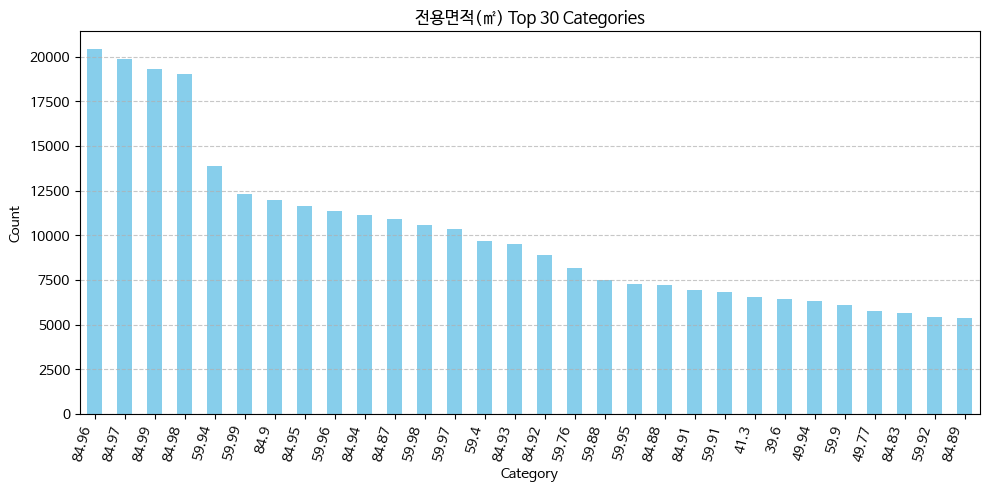

                                                  
                                                  
[ 계약년월 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 198
Unique (%)      : 0.02%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
202006          : 16,364, (1.46%)
201503          : 15,510, (1.39%)
201808          : 14,990, (1.34%)
201707          : 14,922, (1.33%)
201705          : 14,766, (1.32%)
...
202207          : 690, (0.06%)
202211          : 646, (0.06%)
202209          : 620, (0.06%)
202210          : 576, (0.05%)
201609          : 460, (0.04%)
-------------------- Visualize Samples --------------------


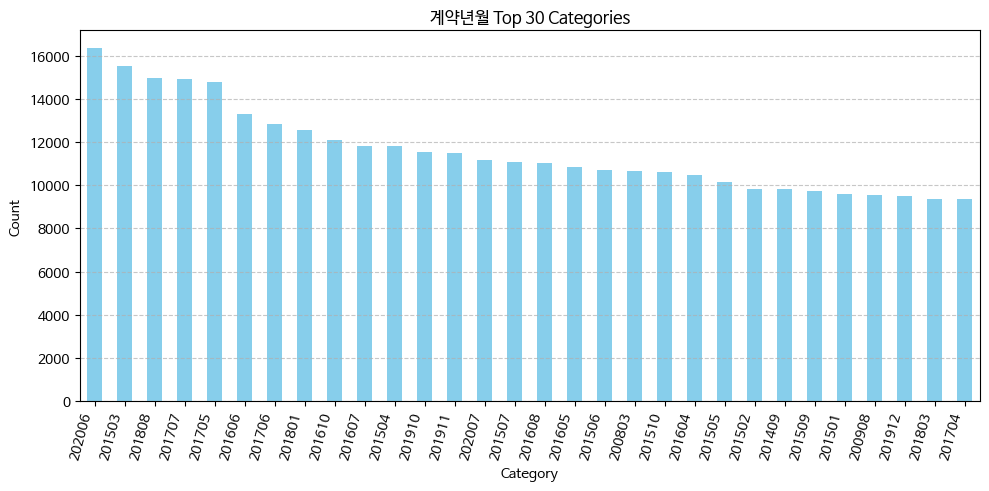

                                                  
                                                  
[ 계약일 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 31
Unique (%)      : 0.00%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
20              : 40,053, (3.58%)
10              : 39,165, (3.50%)
15              : 39,100, (3.49%)
13              : 38,198, (3.41%)
18              : 37,938, (3.39%)
...
30              : 34,873, (3.12%)
3               : 34,525, (3.09%)
2               : 34,409, (3.08%)
29              : 33,950, (3.03%)
31              : 20,806, (1.86%)
-------------------- Visualize Samples --------------------


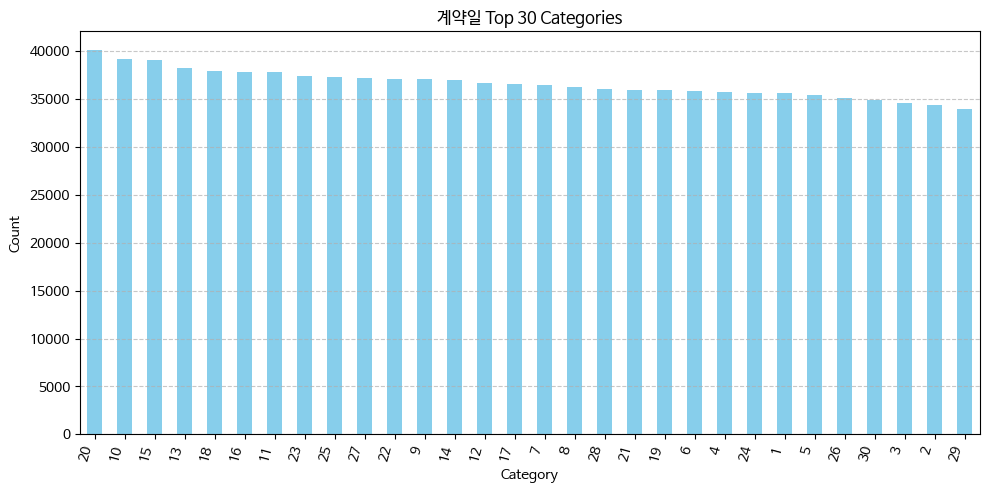

                                                  
                                                  
[ 층 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 73
Unique (%)      : 0.01%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
5               : 82,188, (7.35%)
4               : 82,045, (7.33%)
3               : 80,561, (7.20%)
2               : 77,037, (6.89%)
6               : 73,616, (6.58%)
...
68              : 6, (0.00%)
67              : 6, (0.00%)
65              : 5, (0.00%)
-4              : 4, (0.00%)
69              : 2, (0.00%)
-------------------- Visualize Samples --------------------


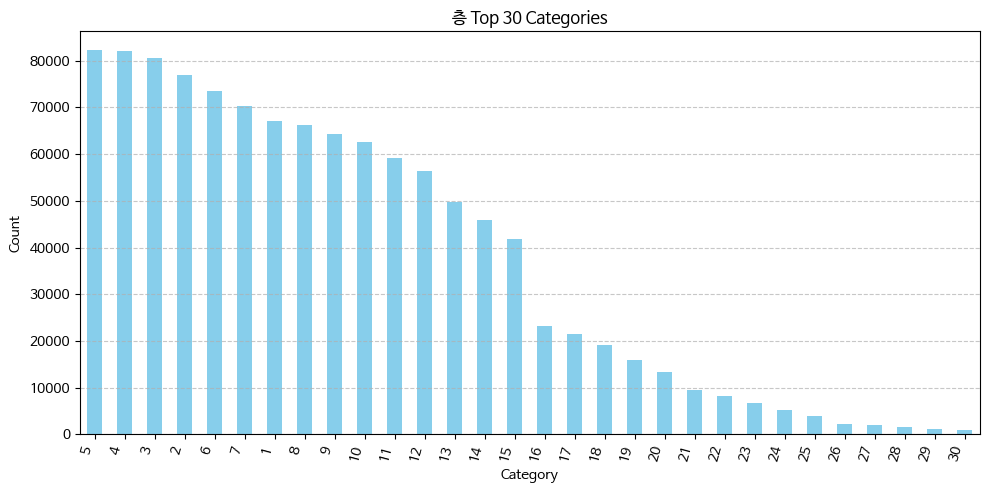

                                                  
                                                  
[ 건축년도 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 60
Unique (%)      : 0.01%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
2004            : 68,487, (6.12%)
2003            : 65,601, (5.86%)
1999            : 59,802, (5.35%)
2000            : 56,851, (5.08%)
1988            : 55,581, (4.97%)
...
1966            : 105, (0.01%)
2023            : 79, (0.01%)
1961            : 54, (0.00%)
1967            : 17, (0.00%)
1965            : 17, (0.00%)
-------------------- Visualize Samples --------------------


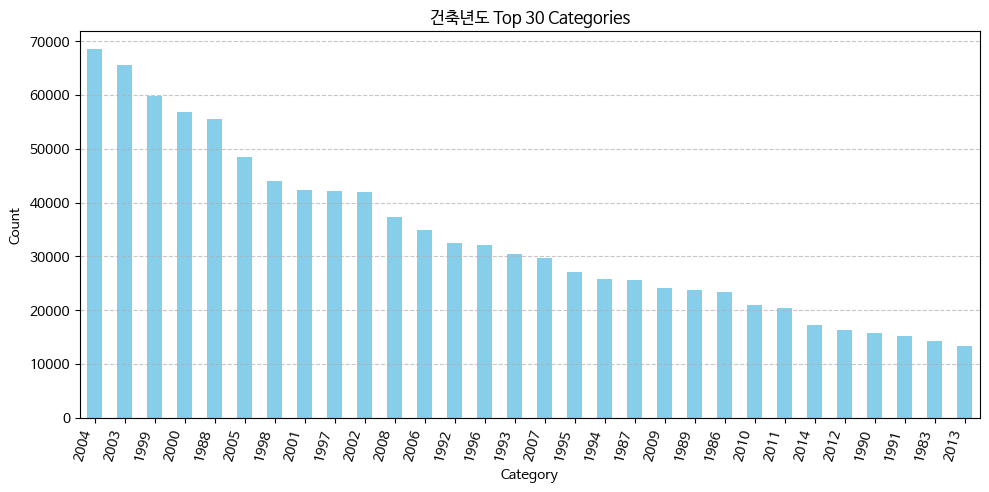

                                                  
                                                  
[ 도로명 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 9232
Unique (%)      : 0.83%
Missing         : 1208
Missing (%)     : 0.11%
Memory size     : 123.99 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 1208
- : 0
-------------------- Samples --------------------
올림픽로 435        : 4,322, (0.39%)
솔샘로 174         : 3,997, (0.36%)
송파대로 345        : 3,603, (0.32%)
성북로4길 52        : 3,487, (0.31%)
양재대로 1340       : 3,369, (0.30%)
...
경인로 193-17      : 1, (0.00%)
답십리로41길 7       : 1, (0.00%)
구로동로18길 44      : 1, (0.00%)
화곡로68길 102      : 1, (0.00%)
도림로8길 21        : 1, (0.00%)
-------------------- Visualize Samples --------------------


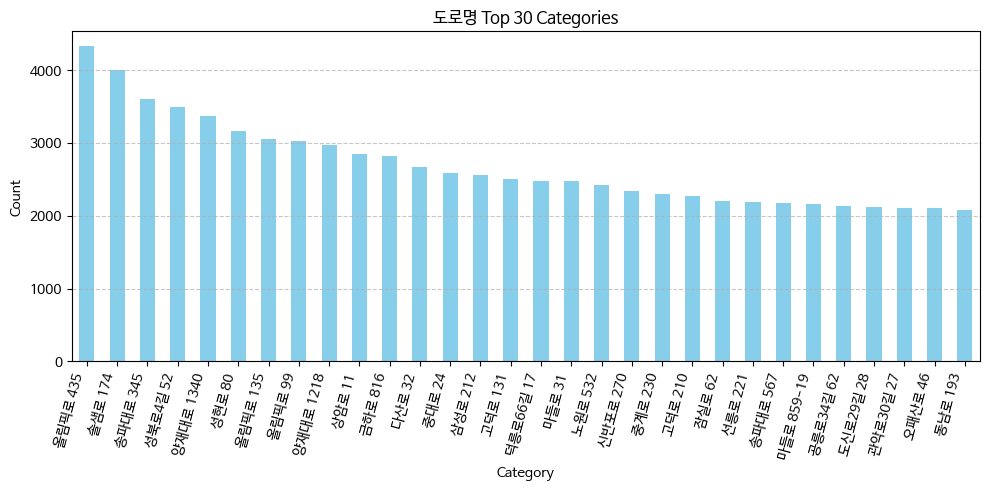

                                                  
                                                  
[ 해제사유발생일 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 1025
Unique (%)      : 0.09%
Missing         : 1112839
Missing (%)     : 99.47%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 1112839
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
20220211.0      : 151, (2.52%)
20200727.0      : 43, (0.72%)
20200714.0      : 40, (0.67%)
20200720.0      : 37, (0.62%)
20200715.0      : 32, (0.53%)
...
20220310.0      : 1, (0.02%)
20220723.0      : 1, (0.02%)
20200809.0      : 1, (0.02%)
20201017.0      : 1, (0.02%)
20221125.0      : 1, (0.02%)
-------------------- Visualize Samples --------------------


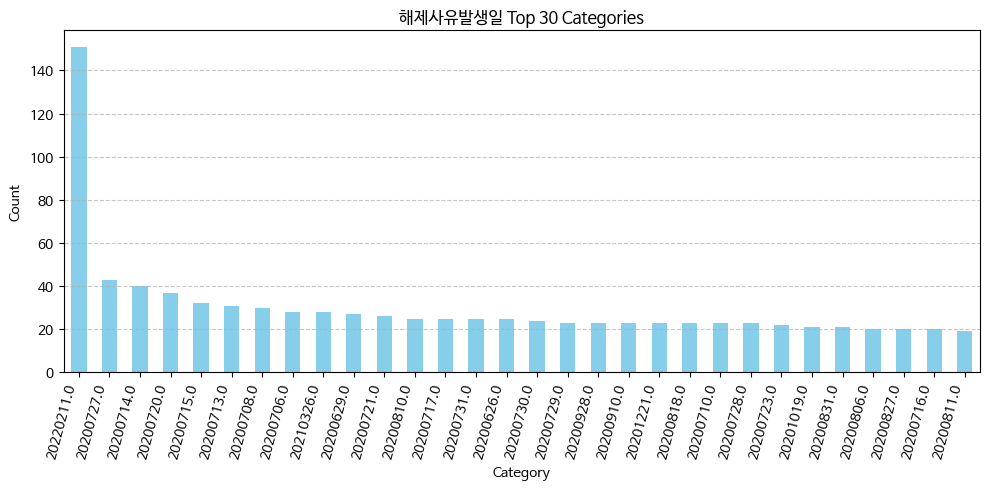

                                                  
                                                  
[ 등기신청일자 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 182
Unique (%)      : 0.02%
Missing         : 1103907
Missing (%)     : 98.67%
Memory size     : 61.99 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 1103907
- : 0
-------------------- Samples --------------------
                : 1,103,907, (98.67%)
20230630        : 585, (0.05%)
20230428        : 394, (0.04%)
20230831        : 391, (0.03%)
20230530        : 367, (0.03%)
...
20230110        : 3, (0.00%)
20230125        : 3, (0.00%)
20230109        : 1, (0.00%)
20230102        : 1, (0.00%)
20230104        : 1, (0.00%)
-------------------- Visualize Samples --------------------


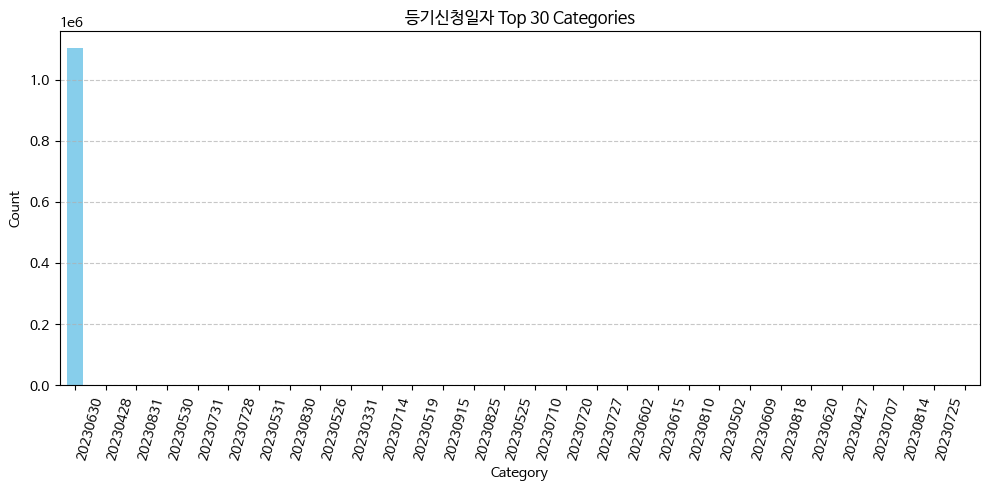

                                                  
                                                  
[ 거래유형 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 3
Unique (%)      : 0.00%
Missing         : 1086451
Missing (%)     : 97.11%
Memory size     : 63.26 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 1086451
-------------------- Samples --------------------
-               : 1,086,451, (97.11%)
중개거래            : 29,271, (2.62%)
직거래             : 3,100, (0.28%)
-------------------- Visualize Samples --------------------


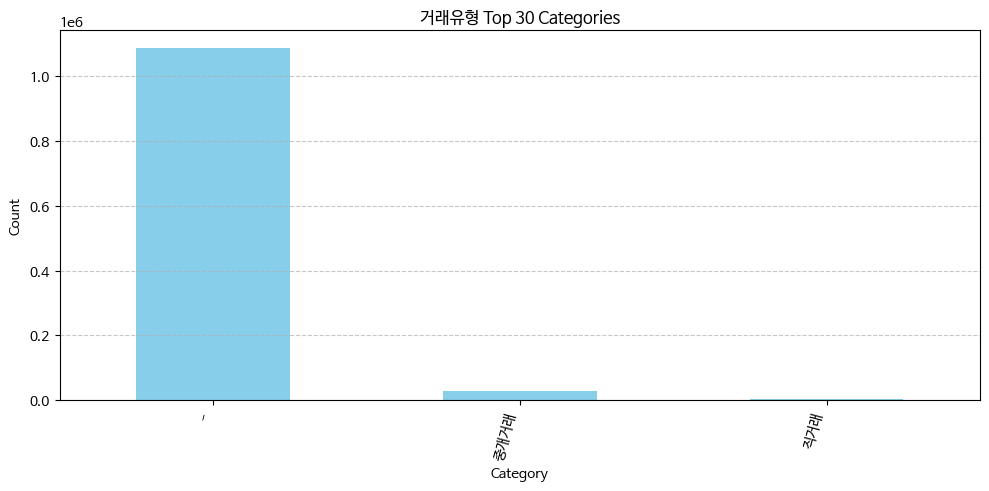

                                                  
                                                  
[ 중개사소재지 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 643
Unique (%)      : 0.06%
Missing         : 1089581
Missing (%)     : 97.39%
Memory size     : 63.46 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 1089581
-------------------- Samples --------------------
-               : 1,089,581, (97.39%)
서울 강남구          : 2,000, (0.18%)
서울 송파구          : 1,995, (0.18%)
서울 노원구          : 1,966, (0.18%)
서울 강동구          : 1,597, (0.14%)
...
서울 금천구, 서울 종로구  : 1, (0.00%)
경기 수원권선구, 서울 성동구 : 1, (0.00%)
광주 서구, 서울 성동구   : 1, (0.00%)
경기 성남수정구, 서울 중구 : 1, (0.00%)
경기 과천시, 서울 강남구  : 1, (0.00%)
-------------------- Visualize Samples --------------------


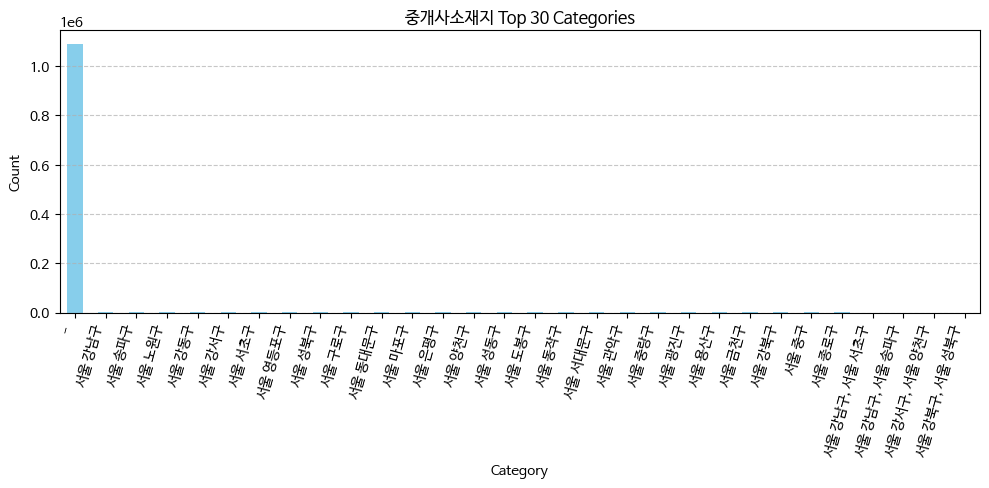

                                                  
                                                  
[ k-단지분류(아파트,주상복합등등) ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 5
Unique (%)      : 0.00%
Missing         : 870691
Missing (%)     : 77.82%
Memory size     : 47.43 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 870691
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
아파트             : 235,994, (95.11%)
주상복합            : 11,360, (4.58%)
도시형 생활주택(주상복합)  : 500, (0.20%)
도시형 생활주택(아파트)   : 152, (0.06%)
연립주택            : 125, (0.05%)
-------------------- Visualize Samples --------------------


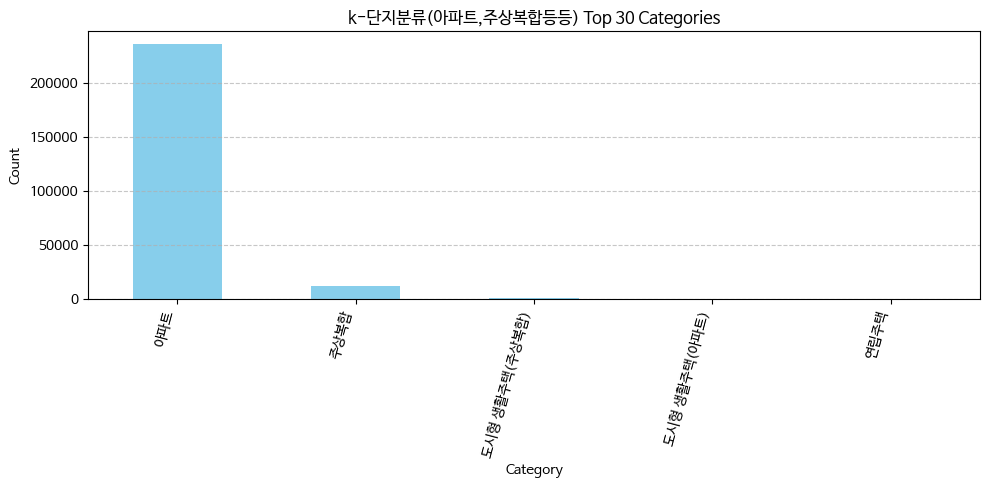

                                                  
                                                  
[ k-전화번호 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 1081
Unique (%)      : 0.10%
Missing         : 870274
Missing (%)     : 77.78%
Memory size     : 40.28 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 870274
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
024162883       : 3,028, (1.22%)
02-575-5024     : 2,816, (1.13%)
024046006       : 2,589, (1.04%)
025677608       : 2,485, (1.00%)
023743863       : 2,360, (0.95%)
...
29748290.0      : 1, (0.00%)
0222099040      : 1, (0.00%)
0220603818      : 1, (0.00%)
025763999       : 1, (0.00%)
25147022.0      : 1, (0.00%)
-------------------- Visualize Samples --------------------


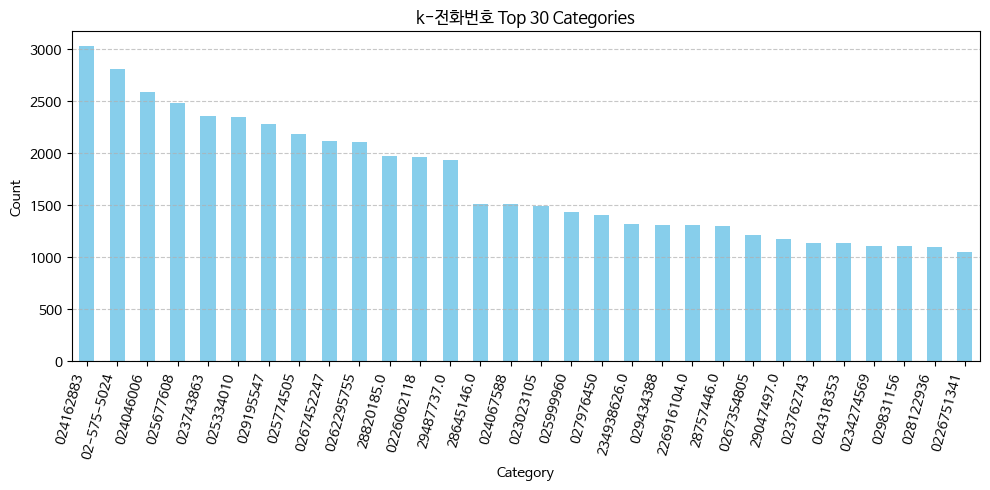

                                                  
                                                  
[ k-팩스번호 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 1364
Unique (%)      : 0.12%
Missing         : 872742
Missing (%)     : 78.01%
Memory size     : 36.42 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 872742
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
02-572-3212     : 2,816, (1.14%)
24162280.0      : 2,470, (1.00%)
025613140       : 2,395, (0.97%)
29797224.0      : 2,378, (0.97%)
25334075.0      : 2,321, (0.94%)
...
025861159       : 1, (0.00%)
025323302       : 1, (0.00%)
0220580592      : 1, (0.00%)
025775587       : 1, (0.00%)
029276238       : 1, (0.00%)
-------------------- Visualize Samples --------------------


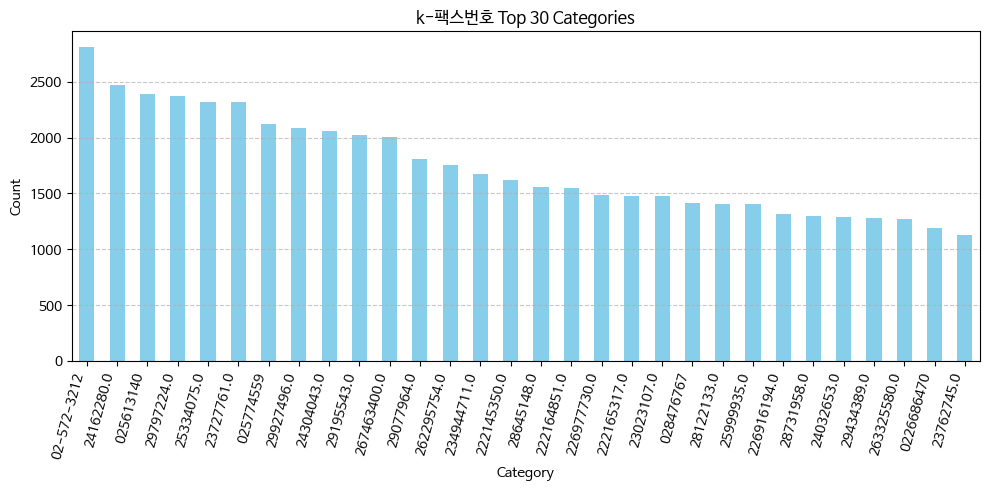

                                                  
                                                  
[ 단지소개기존clob ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 94
Unique (%)      : 0.01%
Missing         : 1050240
Missing (%)     : 93.87%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 1050240
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
4.0             : 23,845, (34.77%)
1474.0          : 2,465, (3.59%)
638.0           : 2,346, (3.42%)
301.0           : 2,093, (3.05%)
2315.0          : 1,558, (2.27%)
...
2039.0          : 118, (0.17%)
63.0            : 113, (0.16%)
217.0           : 111, (0.16%)
24.0            : 107, (0.16%)
1417.0          : 51, (0.07%)
-------------------- Visualize Samples --------------------


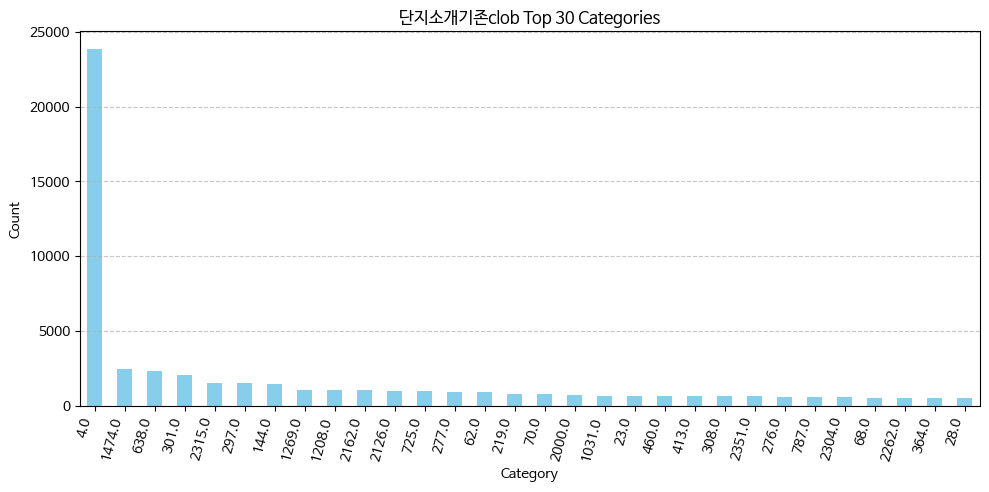

                                                  
                                                  
[ k-세대타입(분양형태) ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 3
Unique (%)      : 0.00%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 46.98 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
분양              : 206,371, (82.79%)
기타              : 40,686, (16.32%)
임대              : 2,202, (0.88%)
-------------------- Visualize Samples --------------------


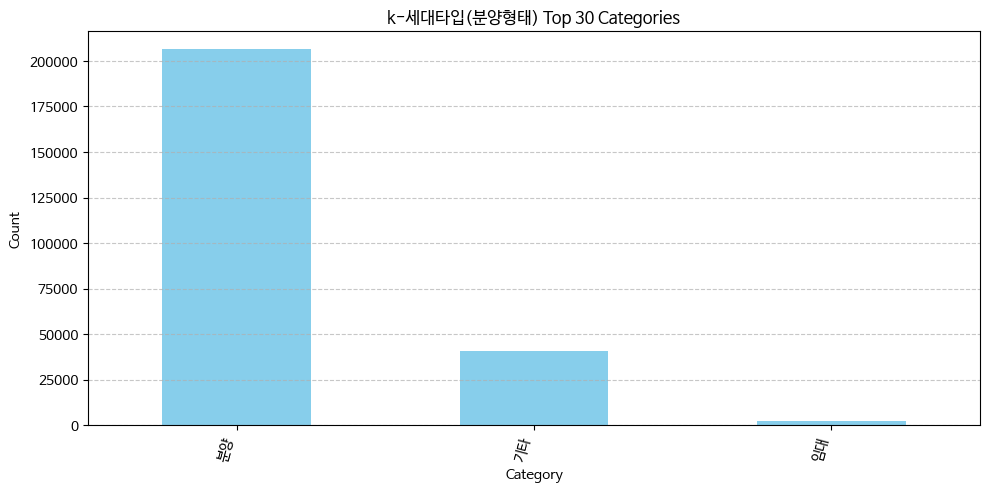

                                                  
                                                  
[ k-관리방식 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 3
Unique (%)      : 0.00%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 47.92 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
위탁관리            : 227,842, (91.41%)
자치관리            : 18,005, (7.22%)
직영              : 3,412, (1.37%)
-------------------- Visualize Samples --------------------


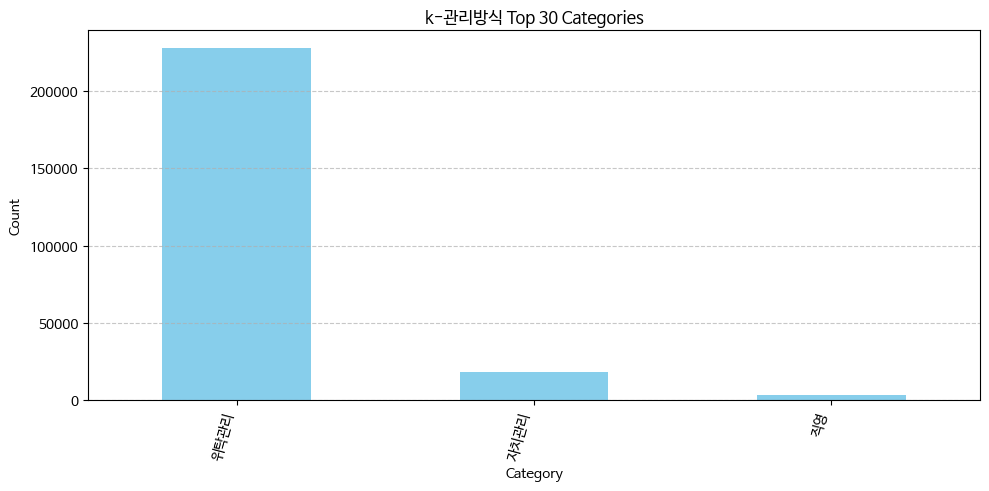

                                                  
                                                  
[ k-복도유형 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 5
Unique (%)      : 0.00%
Missing         : 869890
Missing (%)     : 77.75%
Memory size     : 47.44 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869890
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
계단식             : 123,651, (49.67%)
혼합식             : 84,491, (33.94%)
복도식             : 38,383, (15.42%)
타워형             : 1,340, (0.54%)
기타              : 1,067, (0.43%)
-------------------- Visualize Samples --------------------


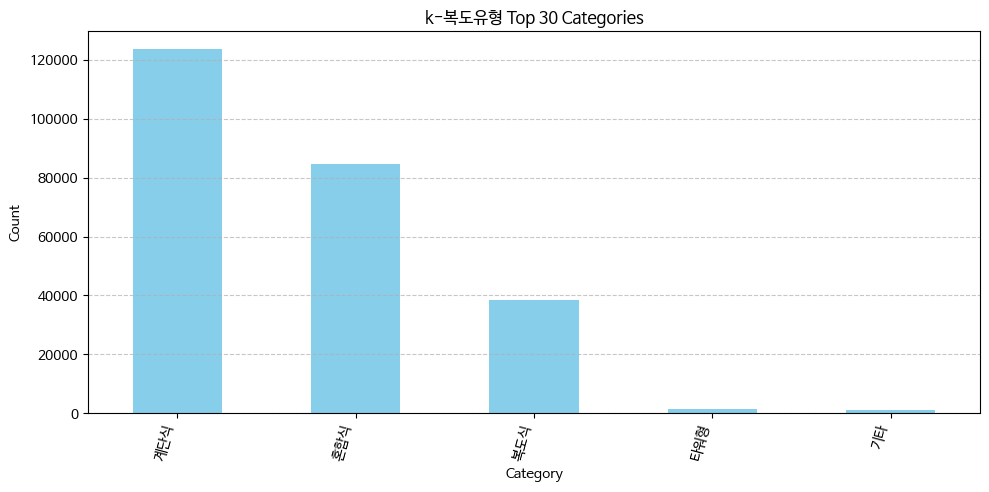

                                                  
                                                  
[ k-난방방식 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 4
Unique (%)      : 0.00%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 47.92 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
개별난방            : 150,739, (60.47%)
지역난방            : 83,891, (33.66%)
중앙난방            : 12,591, (5.05%)
기타              : 2,038, (0.82%)
-------------------- Visualize Samples --------------------


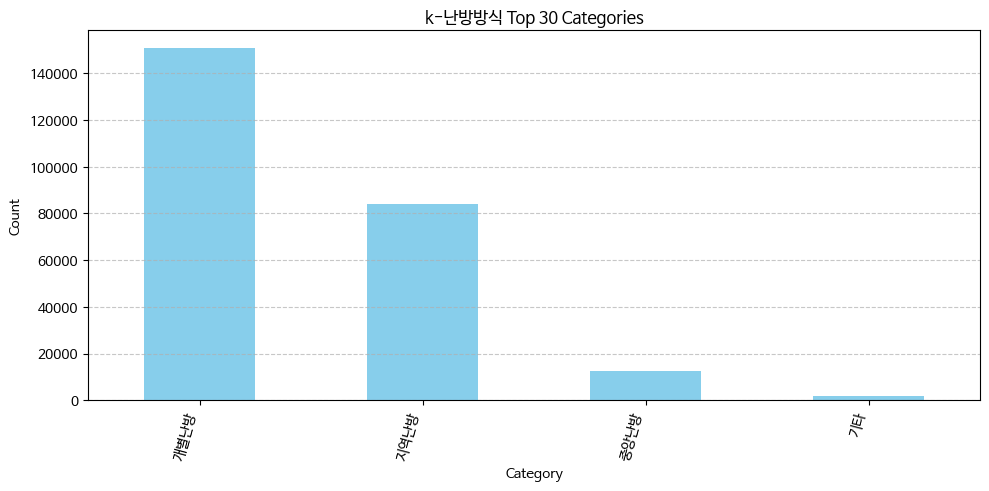

                                                  
                                                  
[ k-전체동수 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 41
Unique (%)      : 0.00%
Missing         : 870630
Missing (%)     : 77.82%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 870630
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
10.0            : 19,801, (7.98%)
2.0             : 17,162, (6.91%)
6.0             : 16,167, (6.51%)
3.0             : 15,271, (6.15%)
4.0             : 13,245, (5.34%)
...
50.0            : 1,365, (0.55%)
37.0            : 1,008, (0.41%)
26.0            : 815, (0.33%)
41.0            : 507, (0.20%)
84.0            : 484, (0.20%)
-------------------- Visualize Samples --------------------


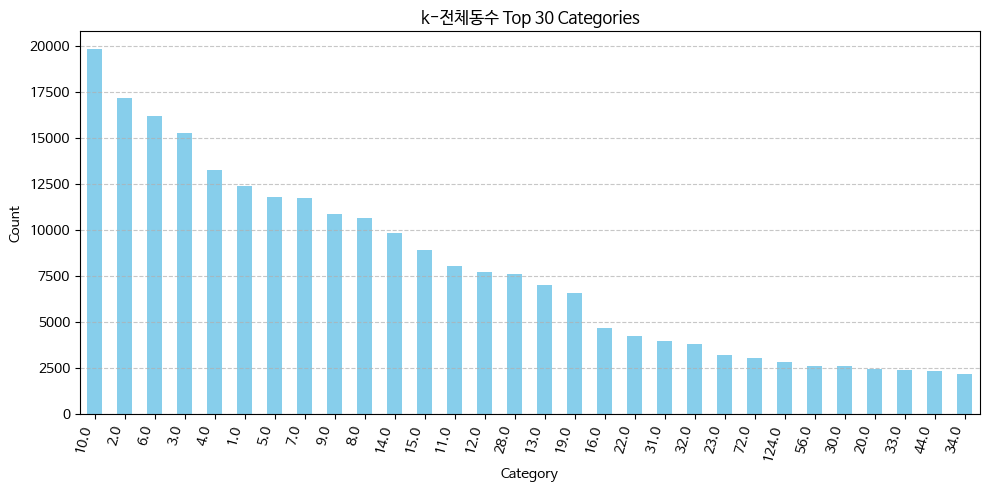

                                                  
                                                  
[ k-전체세대수 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 521
Unique (%)      : 0.05%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
5678.0          : 3,028, (1.21%)
5040.0          : 2,816, (1.13%)
4494.0          : 2,589, (1.04%)
4424.0          : 2,562, (1.03%)
2433.0          : 2,465, (0.99%)
...
494.0           : 2, (0.00%)
514.0           : 2, (0.00%)
799.0           : 1, (0.00%)
243.0           : 1, (0.00%)
1395.0          : 1, (0.00%)
-------------------- Visualize Samples --------------------


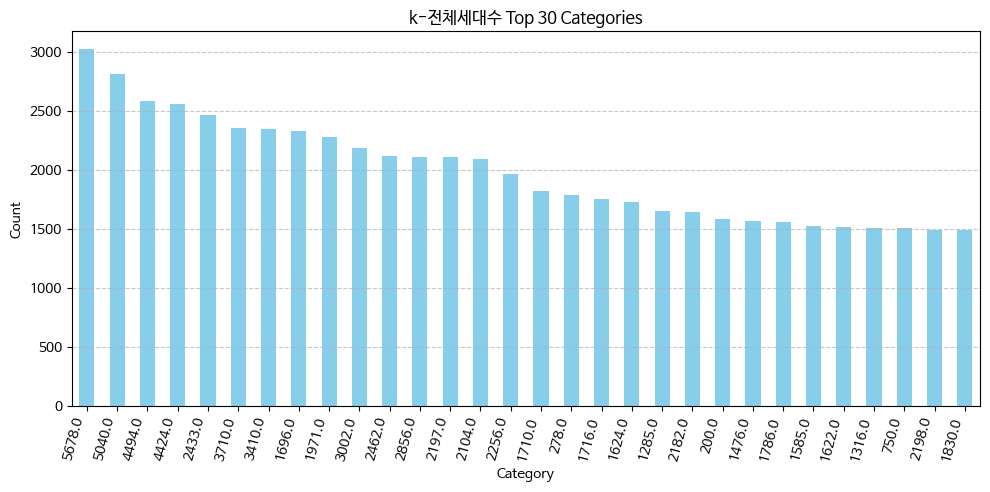

                                                  
                                                  
[ k-건설사(시공사) ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 344
Unique (%)      : 0.03%
Missing         : 871058
Missing (%)     : 77.85%
Memory size     : 48.78 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 871058
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
삼성물산            : 14,081, (5.68%)
대우건설            : 11,454, (4.62%)
현대건설            : 10,430, (4.21%)
대한주택공사          : 7,643, (3.08%)
GS건설            : 6,865, (2.77%)
...
신영건설            : 2, (0.00%)
대림건설(주)         : 1, (0.00%)
자이에스앤디(주)       : 1, (0.00%)
혜림건설            : 1, (0.00%)
삼익건설(주)         : 1, (0.00%)
-------------------- Visualize Samples --------------------


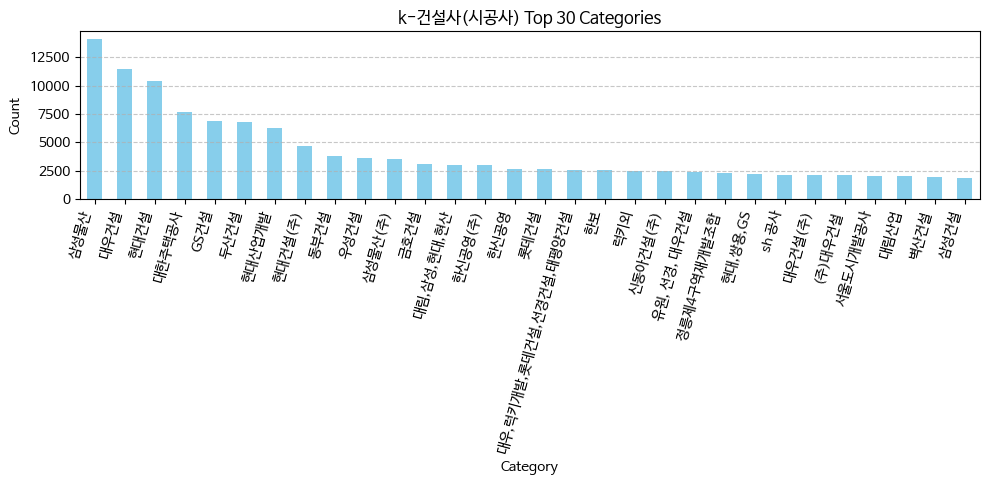

                                                  
                                                  
[ k-시행사 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 555
Unique (%)      : 0.05%
Missing         : 871406
Missing (%)     : 77.89%
Memory size     : 49.75 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 871254
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 152
-------------------- Samples --------------------
SH공사            : 12,495, (5.05%)
대한주택공사          : 7,760, (3.13%)
도시개발공사          : 4,241, (1.71%)
sh공사            : 4,153, (1.68%)
재건축조합           : 4,030, (1.63%)
...
(주)에스떠블유산업개발    : 2, (0.00%)
에이자기관리부동산투자회사 주식회사 : 1, (0.00%)
청명종합건설(주)       : 1, (0.00%)
신길3재정비촉진구역주택재개발정비사업조합 : 1, (0.00%)
개포우성9차모델링조합     : 1, (0.00%)
-------------------- Visualize Samples --------------------


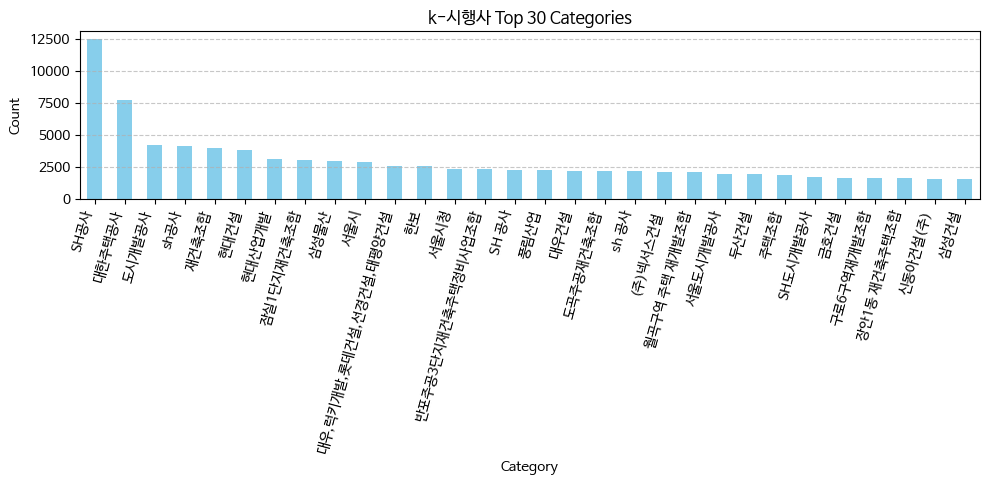

                                                  
                                                  
[ k-사용검사일-사용승인일 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 673
Unique (%)      : 0.06%
Missing         : 869696
Missing (%)     : 77.73%
Memory size     : 45.07 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869696
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
1992-11-18 00:00:00.0 : 3,277, (1.32%)
2008-09-30 00:00:00.0 : 3,028, (1.22%)
1990-09-06 00:00:00.0 : 2,844, (1.14%)
1982-06-04 00:00:00.0 : 2,816, (1.13%)
2005-12-28 00:00:00.0 : 2,623, (1.05%)
...
2023-01-27 00:00:00.0 : 1, (0.00%)
2020-09-24 00:00:00.0 : 1, (0.00%)
2022-11-07 00:00:00.0 : 1, (0.00%)
2022-07-28 00:00:00.0 : 1, (0.00%)
1994-12-07 00:00:00.0 : 1, (0.00%)
-------------------- Visualize S

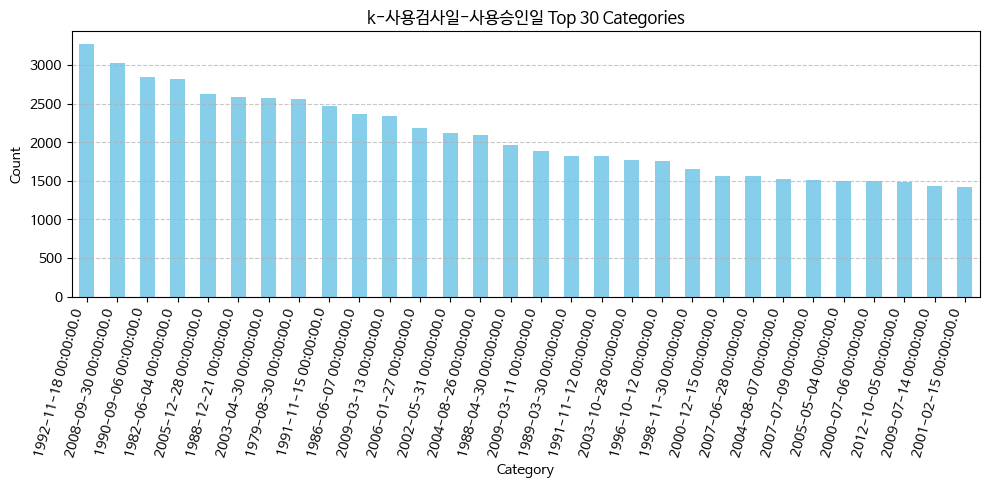

                                                  
                                                  
[ k-연면적 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 734
Unique (%)      : 0.07%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
935380.0        : 3,028, (1.21%)
240629.0        : 2,816, (1.13%)
667132.0        : 2,589, (1.04%)
504698.0        : 2,562, (1.03%)
172371.0        : 2,465, (0.99%)
...
33727.0         : 1, (0.00%)
44951.0         : 1, (0.00%)
123740.0        : 1, (0.00%)
33807.0         : 1, (0.00%)
60621.0         : 1, (0.00%)
-------------------- Visualize Samples --------------------


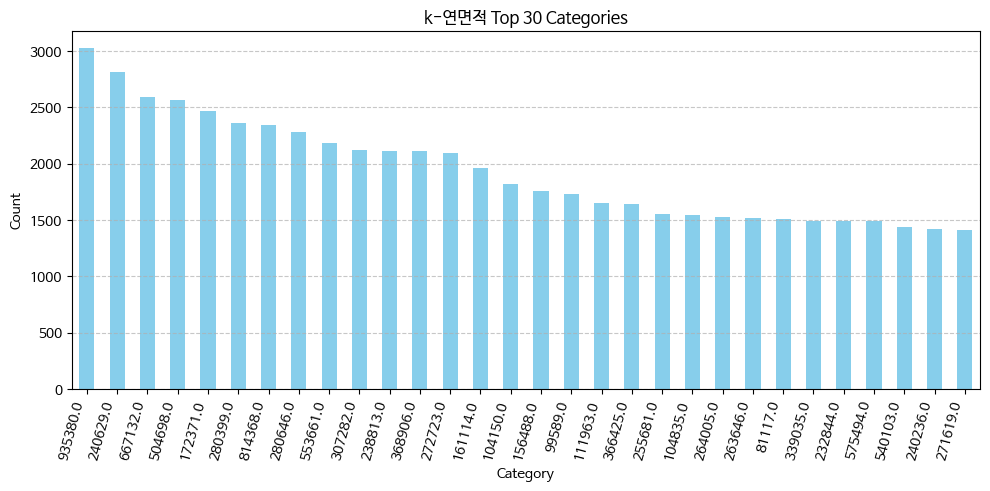

                                                  
                                                  
[ k-주거전용면적 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 739
Unique (%)      : 0.07%
Missing         : 869608
Missing (%)     : 77.73%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869608
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
470140.0        : 3,028, (1.22%)
242461.0        : 2,816, (1.13%)
537573.0        : 2,589, (1.04%)
353089.0        : 2,562, (1.03%)
117086.0        : 2,465, (0.99%)
...
24878.0         : 1, (0.00%)
55255.0         : 1, (0.00%)
16124.0         : 1, (0.00%)
10403.0         : 1, (0.00%)
37677.0         : 1, (0.00%)
-------------------- Visualize Samples --------------------


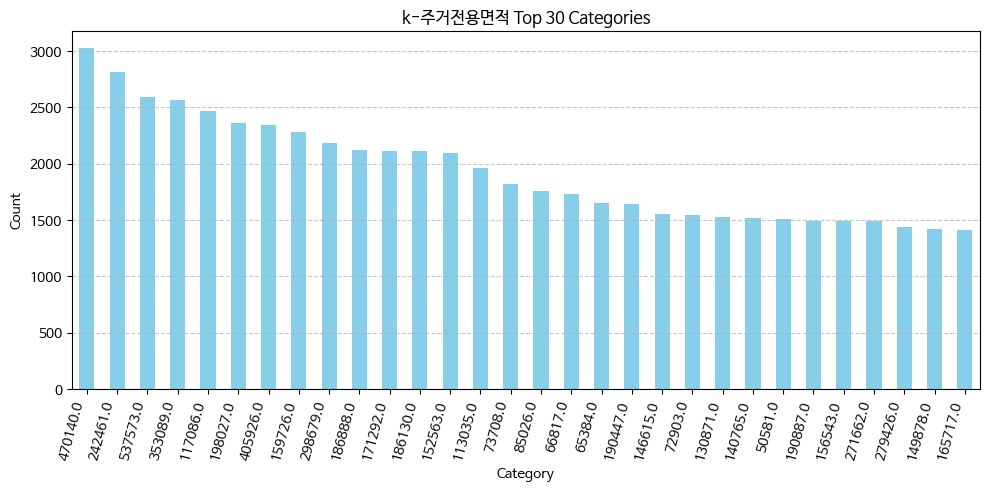

                                                  
                                                  
[ k-관리비부과면적 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 735
Unique (%)      : 0.07%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
618666.0        : 3,028, (1.21%)
240629.0        : 2,816, (1.13%)
646257.0        : 2,589, (1.04%)
470732.0        : 2,562, (1.03%)
166985.0        : 2,465, (0.99%)
...
77047.0         : 1, (0.00%)
14169.0         : 1, (0.00%)
31174.0         : 1, (0.00%)
22782.0         : 1, (0.00%)
57799.0         : 1, (0.00%)
-------------------- Visualize Samples --------------------


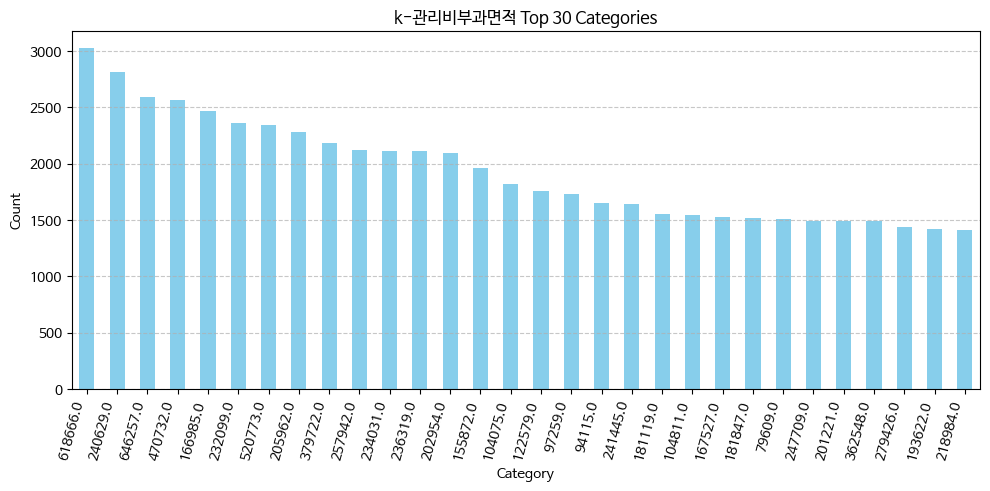

                                                  
                                                  
[ k-전용면적별세대현황(60㎡이하) ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 348
Unique (%)      : 0.03%
Missing         : 869608
Missing (%)     : 77.73%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869608
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
0.0             : 53,781, (21.58%)
1150.0          : 3,028, (1.22%)
370.0           : 2,875, (1.15%)
4975.0          : 2,816, (1.13%)
750.0           : 2,730, (1.10%)
...
543.0           : 3, (0.00%)
406.0           : 3, (0.00%)
438.0           : 1, (0.00%)
9.0             : 1, (0.00%)
1395.0          : 1, (0.00%)
-------------------- Visualize Samples --------------------


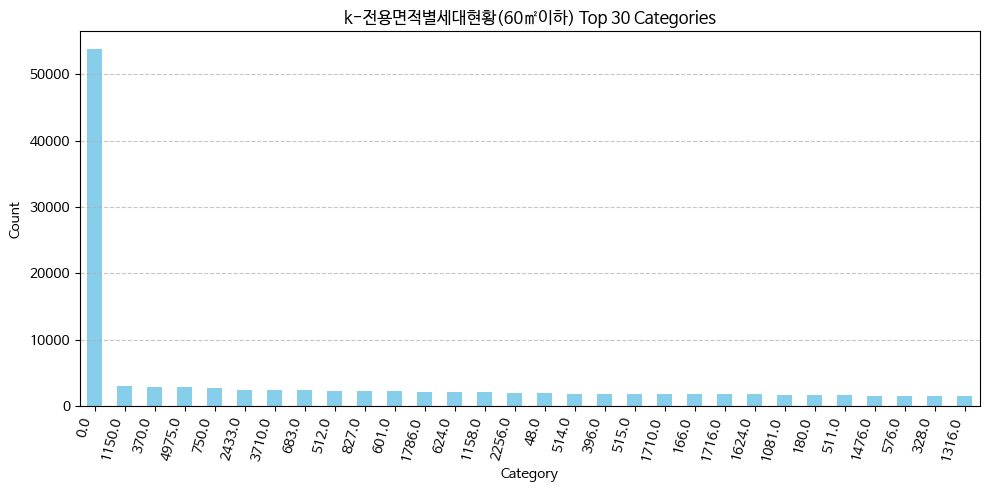

                                                  
                                                  
[ k-전용면적별세대현황(60㎡~85㎡이하) ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 387
Unique (%)      : 0.03%
Missing         : 869608
Missing (%)     : 77.73%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869608
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
0.0             : 42,969, (17.24%)
688.0           : 3,279, (1.32%)
4042.0          : 3,028, (1.22%)
65.0            : 2,969, (1.19%)
1500.0          : 2,589, (1.04%)
...
25.0            : 6, (0.00%)
465.0           : 6, (0.00%)
850.0           : 3, (0.00%)
273.0           : 3, (0.00%)
333.0           : 1, (0.00%)
-------------------- Visualize Samples --------------------


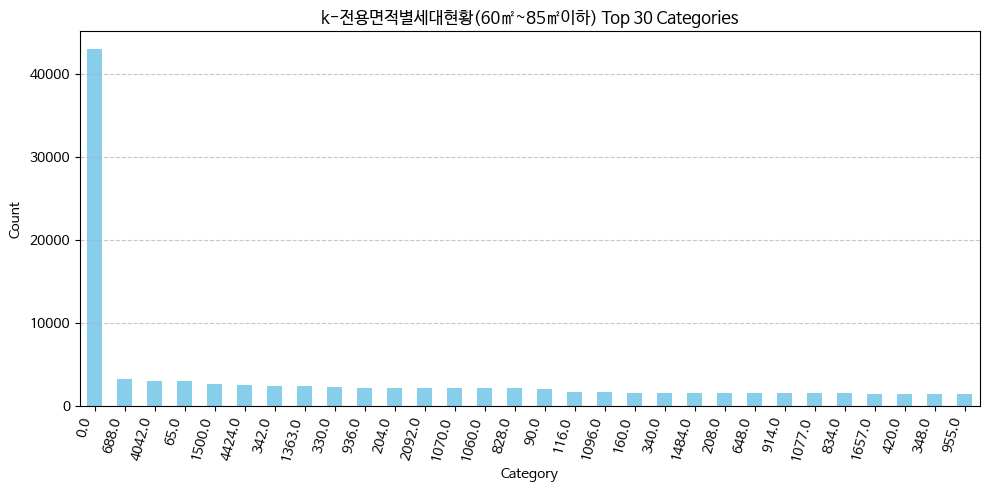

                                                  
                                                  
[ k-85㎡~135㎡이하 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 244
Unique (%)      : 0.02%
Missing         : 869608
Missing (%)     : 77.73%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869608
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
0.0             : 99,459, (39.91%)
90.0            : 3,225, (1.29%)
486.0           : 3,028, (1.22%)
900.0           : 2,589, (1.04%)
456.0           : 2,554, (1.02%)
...
9.0             : 32, (0.01%)
220.0           : 14, (0.01%)
487.0           : 14, (0.01%)
2.0             : 12, (0.00%)
494.0           : 2, (0.00%)
-------------------- Visualize Samples --------------------


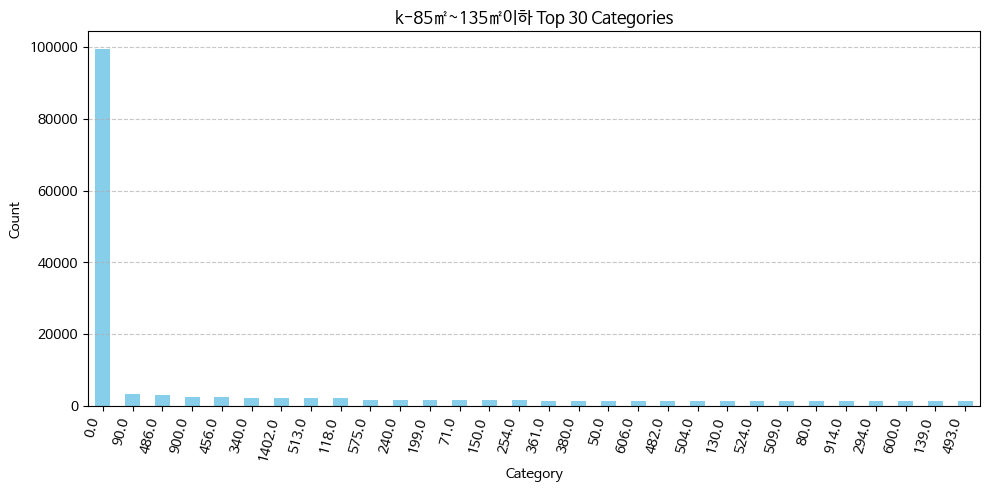

                                                  
                                                  
[ k-135㎡초과 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 1
Unique (%)      : 0.00%
Missing         : 1118495
Missing (%)     : 99.97%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 1118495
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
70.0            : 327, (100.00%)
-------------------- Visualize Samples --------------------


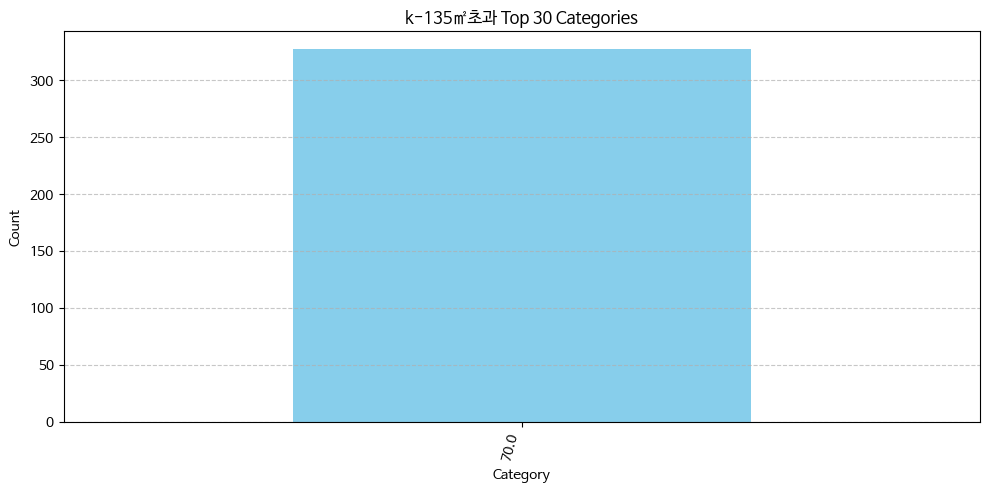

                                                  
                                                  
[ k-홈페이지 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 221
Unique (%)      : 0.02%
Missing         : 1005647
Missing (%)     : 89.88%
Memory size     : 40.18 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 1005647
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
없음              : 3,606, (3.19%)
www.jsls.co.kr  : 3,028, (2.68%)
gaepo001@naver.com : 2,816, (2.49%)
www.oftapt.com  : 2,589, (2.29%)
성산시영.apt.co.kr  : 2,360, (2.09%)
...
bbgran.xisad.co.kr : 6, (0.01%)
www. 자양12구역지역재개발조합 : 6, (0.01%)
cafe.naver.com  : 3, (0.00%)
thesharp-trieh.hthomeservice.com/#/feeManage?_k=vm58ep : 1, (0.00%)
http://www.i-sh.co.kr/happy/intro.do : 1, (0.00%)
-------------------- Visuali

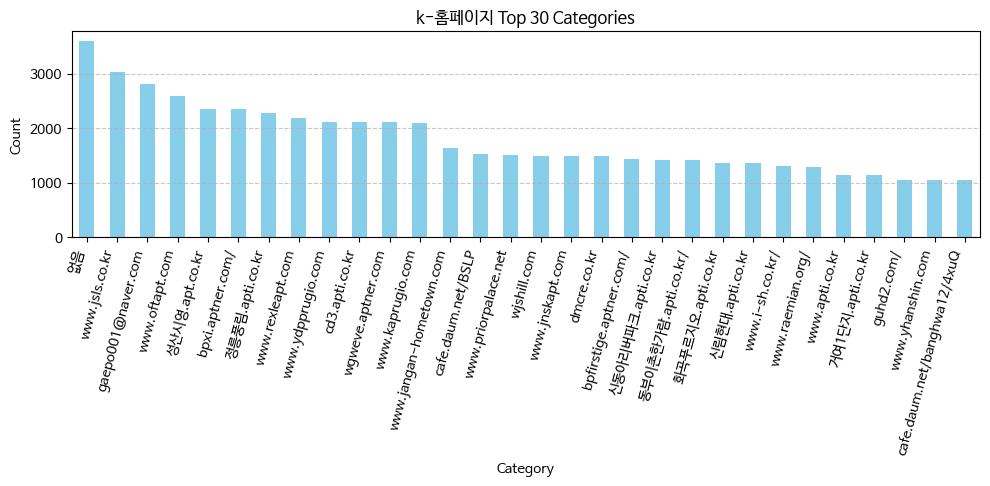

                                                  
                                                  
[ k-등록일자 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 126
Unique (%)      : 0.01%
Missing         : 1107832
Missing (%)     : 99.02%
Memory size     : 34.63 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 1107832
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
2017-02-01 10:49:21.0 : 1,857, (16.90%)
2017-02-10 12:21:22.0 : 710, (6.46%)
2019-01-03 07:03:23.0 : 484, (4.40%)
2017-04-18 02:58:24.0 : 306, (2.78%)
2017-09-06 06:35:46.0 : 216, (1.97%)
...
2022-01-05 18:02:23.0 : 1, (0.01%)
2022-08-04 21:04:18.0 : 1, (0.01%)
2020-12-31 22:40:22.0 : 1, (0.01%)
2022-12-06 02:25:40.0 : 1, (0.01%)
2023-02-18 07:24:46.0 : 1, (0.01%)
-------------------- Visualize Samples -----

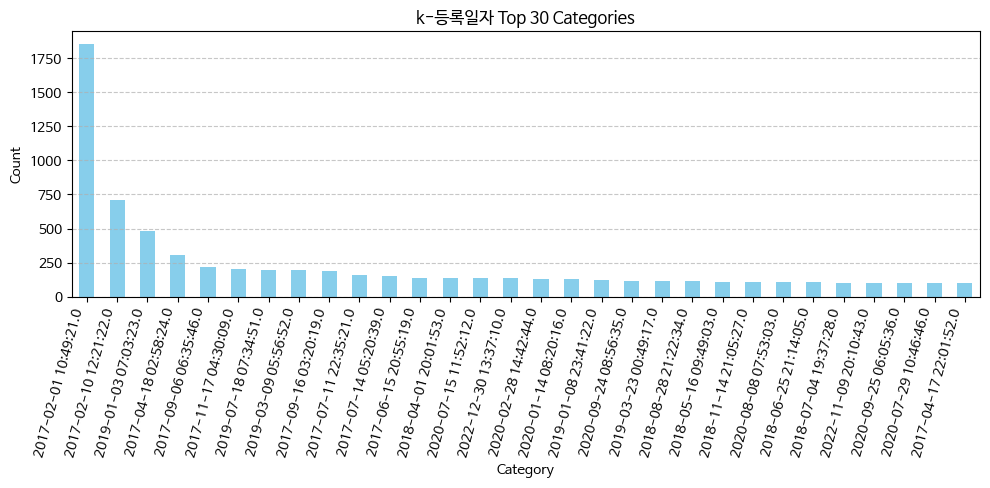

                                                  
                                                  
[ k-수정일자 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 743
Unique (%)      : 0.07%
Missing         : 869608
Missing (%)     : 77.73%
Memory size     : 45.08 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869608
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
2023-09-20 21:38:55.0 : 3,028, (1.22%)
2020-02-17 06:10:24.0 : 2,816, (1.13%)
2023-09-20 22:10:18.0 : 2,589, (1.04%)
2023-09-23 17:49:17.0 : 2,562, (1.03%)
2023-09-25 09:18:00.0 : 2,465, (0.99%)
...
2023-09-25 17:08:03.0 : 1, (0.00%)
2023-09-25 16:58:13.0 : 1, (0.00%)
2023-09-25 16:31:18.0 : 1, (0.00%)
2023-09-23 08:21:37.0 : 1, (0.00%)
2023-09-25 07:49:22.0 : 1, (0.00%)
-------------------- Visualize Samples 

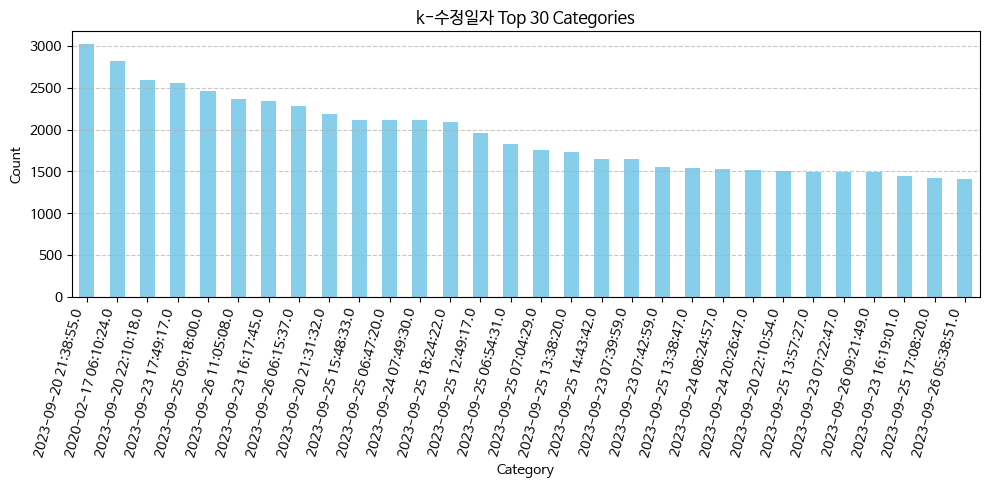

                                                  
                                                  
[ 고용보험관리번호 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 526
Unique (%)      : 0.05%
Missing         : 913304
Missing (%)     : 81.63%
Memory size     : 41.41 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 913304
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
909-01-23103-1  : 3,028, (1.47%)
21380014370     : 2,816, (1.37%)
908-00-99517-1  : 2,562, (1.25%)
907-009-67911   : 2,465, (1.20%)
907-00-16928-1  : 2,360, (1.15%)
...
92023031541     : 21, (0.01%)
91919837281     : 14, (0.01%)
918-15-59912-1  : 14, (0.01%)
206-82-61203-0  : 3, (0.00%)
21780016330     : 1, (0.00%)
-------------------- Visualize Samples --------------------


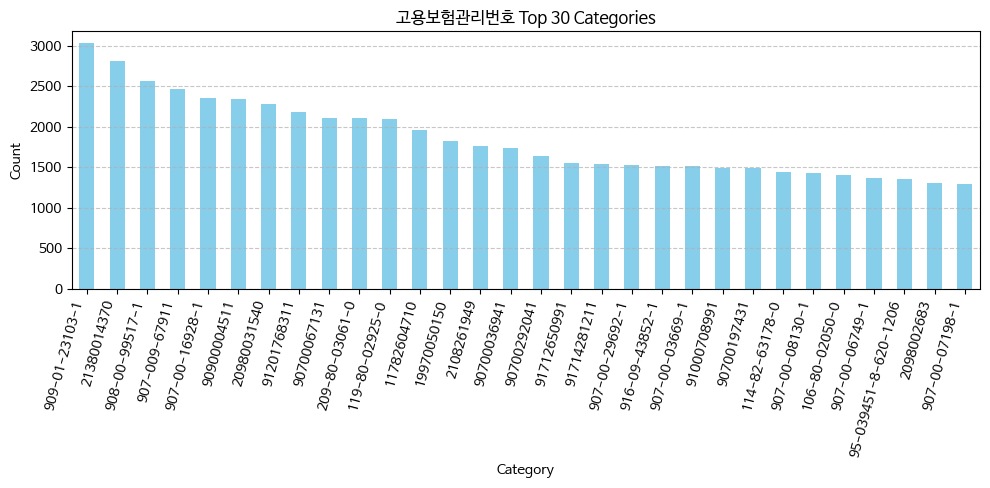

                                                  
                                                  
[ 경비비관리형태 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 4
Unique (%)      : 0.00%
Missing         : 870988
Missing (%)     : 77.85%
Memory size     : 46.94 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 870988
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
위탁              : 206,401, (83.28%)
직영              : 33,526, (13.53%)
위탁+직영           : 6,108, (2.46%)
기타              : 1,799, (0.73%)
-------------------- Visualize Samples --------------------


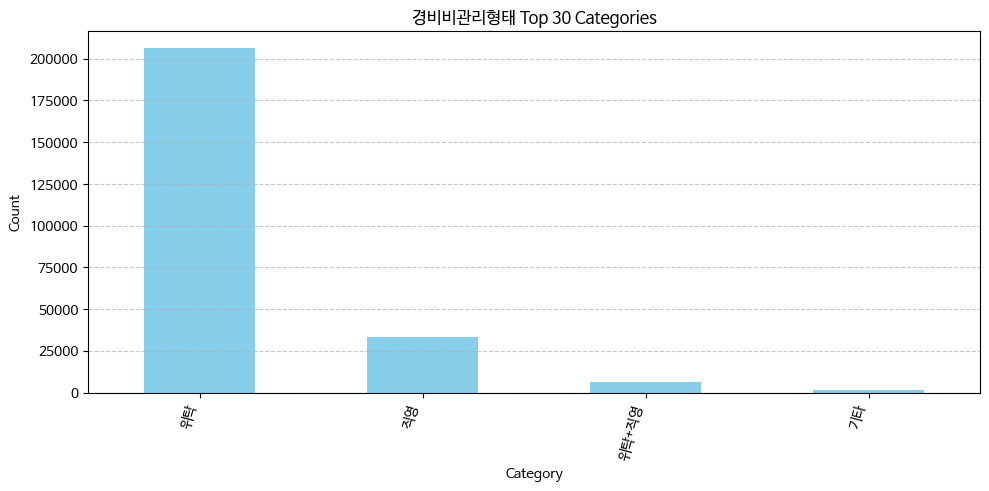

                                                  
                                                  
[ 세대전기계약방법 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 2
Unique (%)      : 0.00%
Missing         : 878747
Missing (%)     : 78.54%
Memory size     : 47.42 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 878747
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
종합계약            : 122,973, (51.22%)
단일계약            : 117,102, (48.78%)
-------------------- Visualize Samples --------------------


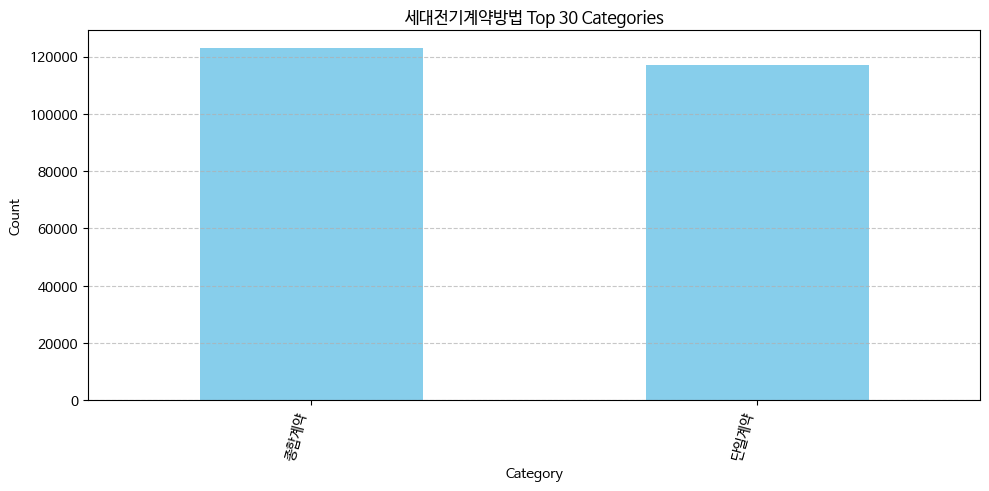

                                                  
                                                  
[ 청소비관리형태 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 4
Unique (%)      : 0.00%
Missing         : 871178
Missing (%)     : 77.87%
Memory size     : 46.92 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 871178
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
위탁              : 225,016, (90.86%)
직영              : 15,052, (6.08%)
위탁+직영           : 4,127, (1.67%)
기타              : 3,449, (1.39%)
-------------------- Visualize Samples --------------------


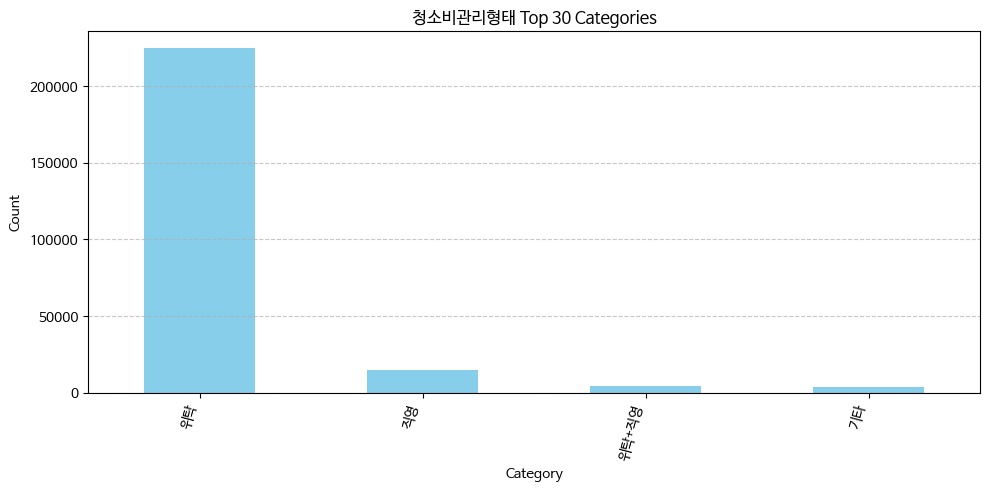

                                                  
                                                  
[ 건축면적 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 455
Unique (%)      : 0.04%
Missing         : 869714
Missing (%)     : 77.73%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869714
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
0.0             : 117,399, (47.13%)
49266.41        : 2,589, (1.04%)
172371.0        : 2,465, (0.99%)
25737.0         : 2,346, (0.94%)
20457.82        : 2,187, (0.88%)
...
1044.15         : 1, (0.00%)
2724.46         : 1, (0.00%)
2309.45         : 1, (0.00%)
6329.59         : 1, (0.00%)
2909.14         : 1, (0.00%)
-------------------- Visualize Samples --------------------


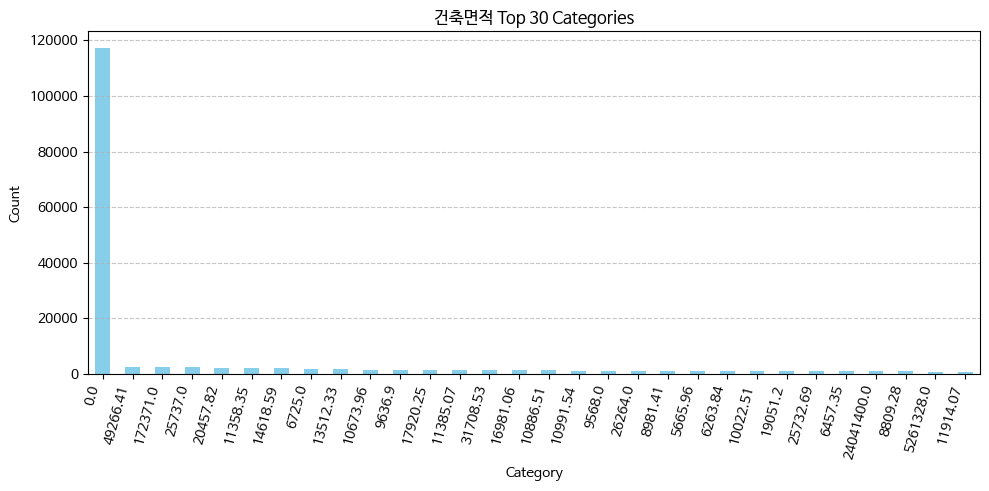

                                                  
                                                  
[ 주차대수 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 526
Unique (%)      : 0.05%
Missing         : 869714
Missing (%)     : 77.73%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869714
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
0.0             : 17,945, (7.20%)
2.0             : 3,413, (1.37%)
1.0             : 2,852, (1.14%)
4245.0          : 2,589, (1.04%)
3021.0          : 2,562, (1.03%)
...
657.0           : 2, (0.00%)
305.0           : 1, (0.00%)
984.0           : 1, (0.00%)
287.0           : 1, (0.00%)
363.0           : 1, (0.00%)
-------------------- Visualize Samples --------------------


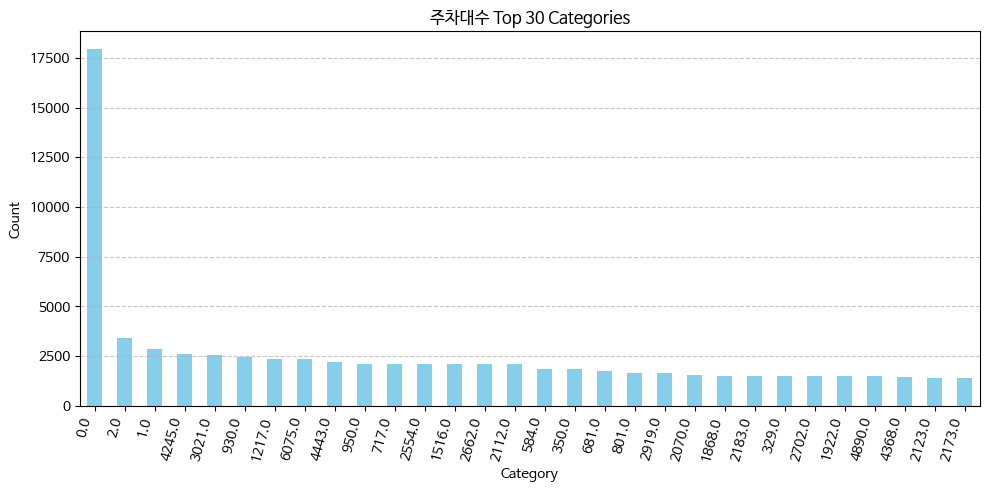

                                                  
                                                  
[ 기타/의무/임대/임의=1/2/3/4 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 4
Unique (%)      : 0.00%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 46.98 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
의무              : 239,198, (95.96%)
기타              : 4,177, (1.68%)
임의              : 3,682, (1.48%)
임대              : 2,202, (0.88%)
-------------------- Visualize Samples --------------------


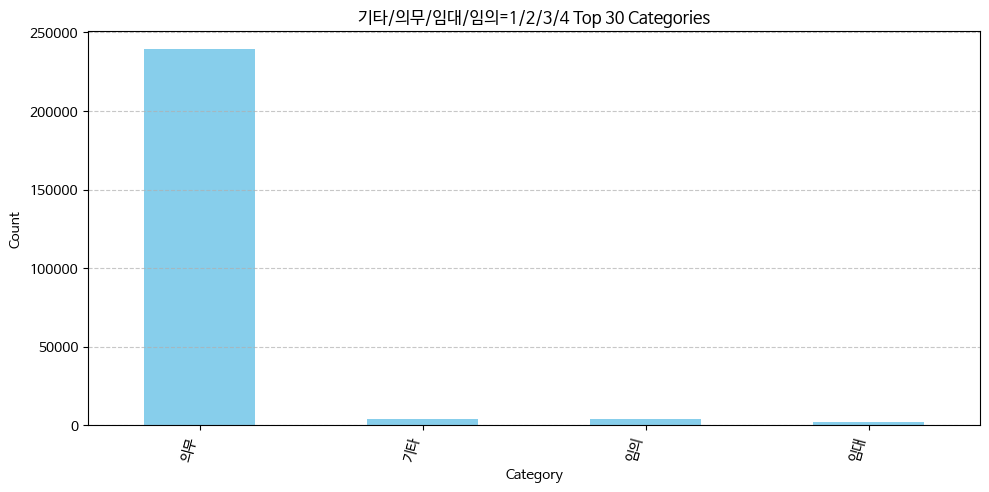

                                                  
                                                  
[ 단지승인일 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 735
Unique (%)      : 0.07%
Missing         : 870286
Missing (%)     : 77.79%
Memory size     : 45.05 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 870286
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
2013-06-23 12:47:34.0 : 3,028, (1.22%)
2013-06-23 14:21:02.0 : 2,816, (1.13%)
2015-01-12 11:06:54.0 : 2,589, (1.04%)
2017-04-12 17:26:04.0 : 2,562, (1.03%)
2019-01-03 16:13:52.0 : 2,465, (0.99%)
...
2022-02-23 13:01:10.0 : 1, (0.00%)
2021-01-06 09:06:12.0 : 1, (0.00%)
2022-08-11 16:44:51.0 : 1, (0.00%)
2022-12-12 12:50:50.0 : 1, (0.00%)
2016-05-27 17:03:25.0 : 1, (0.00%)
-------------------- Visualize Samples -

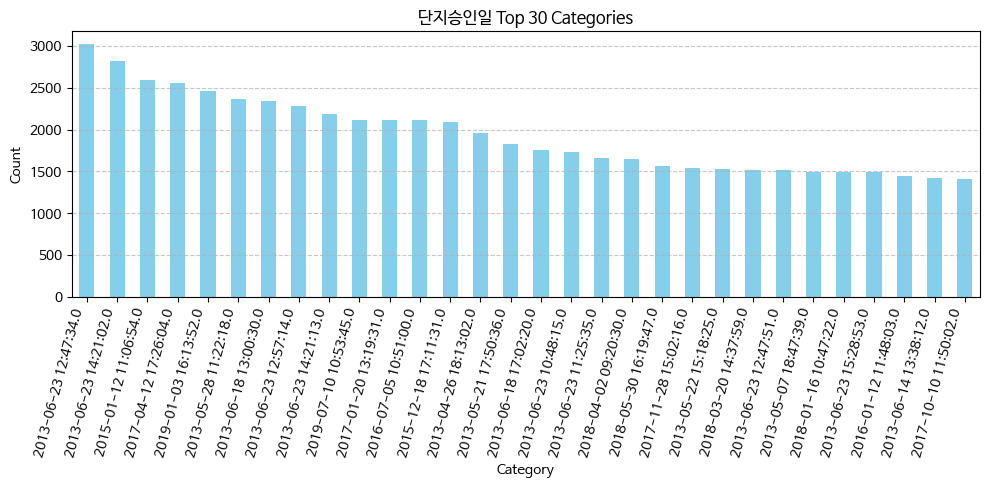

                                                  
                                                  
[ 사용허가여부 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 1
Unique (%)      : 0.00%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 40.32 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
Y               : 249,259, (100.00%)
-------------------- Visualize Samples --------------------


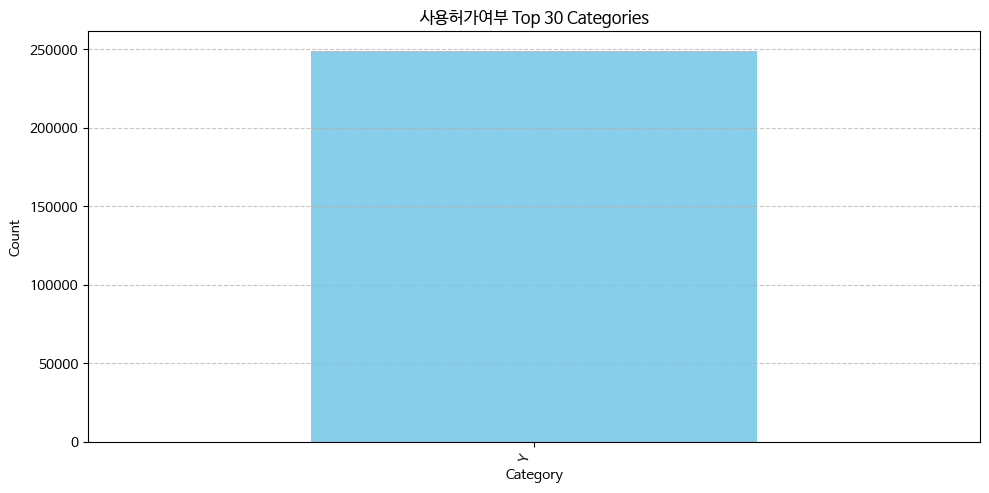

                                                  
                                                  
[ 관리비 업로드 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 2
Unique (%)      : 0.00%
Missing         : 869563
Missing (%)     : 77.72%
Memory size     : 40.32 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869563
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
N               : 245,117, (98.34%)
Y               : 4,142, (1.66%)
-------------------- Visualize Samples --------------------


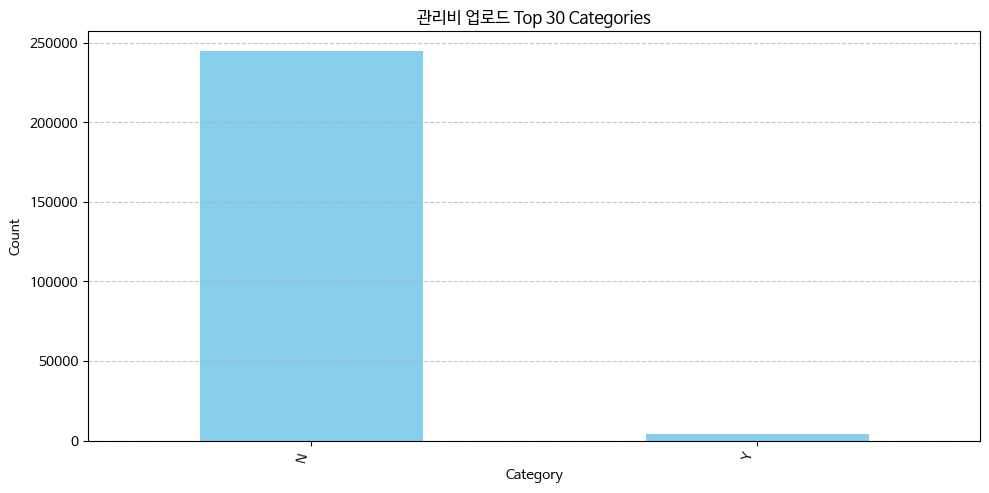

                                                  
                                                  
[ 좌표X ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 741
Unique (%)      : 0.07%
Missing         : 869670
Missing (%)     : 77.73%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869670
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
127.088451      : 3,028, (1.22%)
127.0585214     : 2,816, (1.13%)
127.1143761     : 2,589, (1.04%)
127.0650701     : 2,562, (1.03%)
127.0665685     : 2,465, (0.99%)
...
126.904871      : 1, (0.00%)
126.916553      : 1, (0.00%)
126.885457      : 1, (0.00%)
127.0957516     : 1, (0.00%)
127.0701578     : 1, (0.00%)
-------------------- Visualize Samples --------------------


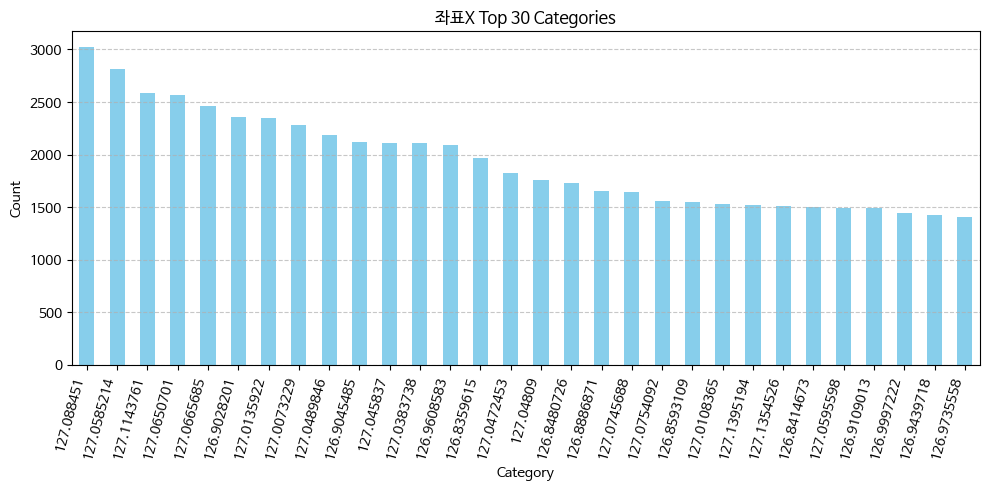

                                                  
                                                  
[ 좌표Y ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 741
Unique (%)      : 0.07%
Missing         : 869670
Missing (%)     : 77.73%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869670
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
37.5127515      : 3,028, (1.22%)
37.4800022      : 2,816, (1.13%)
37.4885215      : 2,589, (1.04%)
37.4977415      : 2,562, (1.03%)
37.6427243      : 2,465, (0.99%)
...
37.488308       : 1, (0.00%)
37.507791       : 1, (0.00%)
37.520028       : 1, (0.00%)
37.5855607      : 1, (0.00%)
37.6301175      : 1, (0.00%)
-------------------- Visualize Samples --------------------


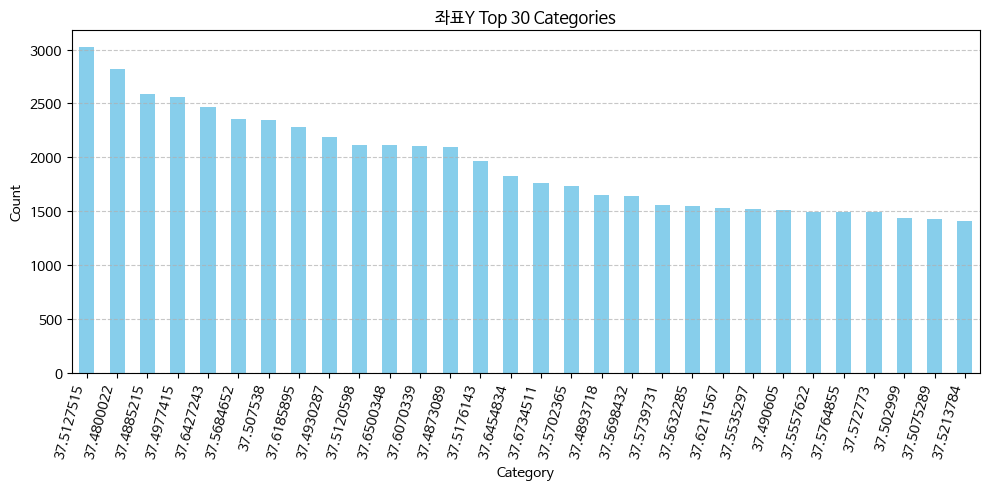

                                                  
                                                  
[ 단지신청일 ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 259
Unique (%)      : 0.02%
Missing         : 869625
Missing (%)     : 77.73%
Memory size     : 45.08 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 869625
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
2013-03-07 09:46:18.0 : 16,435, (6.60%)
2013-03-07 09:46:36.0 : 11,794, (4.73%)
2013-03-07 09:46:19.0 : 11,590, (4.65%)
2013-03-07 09:46:42.0 : 7,929, (3.18%)
2013-03-07 09:46:20.0 : 7,569, (3.04%)
...
2023-04-27 13:20:30.0 : 1, (0.00%)
2022-02-23 11:05:05.0 : 1, (0.00%)
2022-08-11 16:36:06.0 : 1, (0.00%)
2022-12-12 11:52:27.0 : 1, (0.00%)
2021-01-05 11:47:31.0 : 1, (0.00%)
-------------------- Visualize Sample

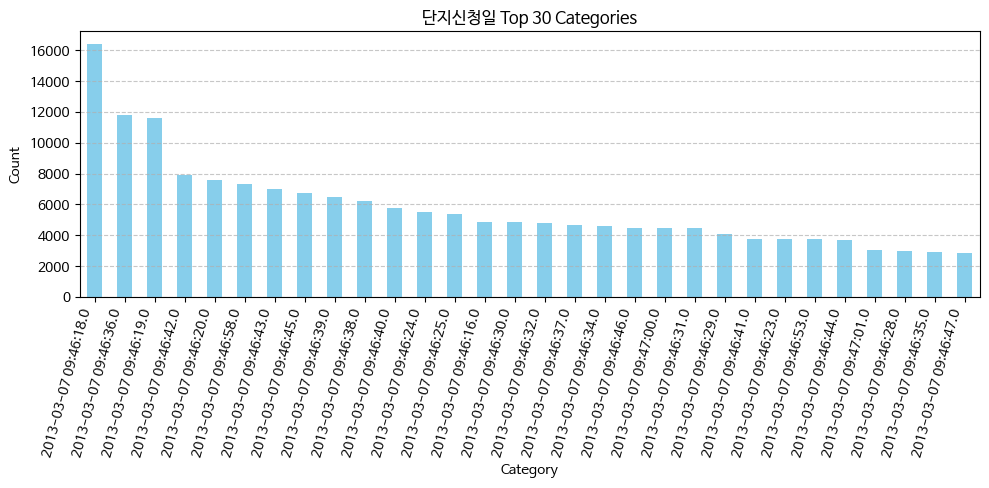

                                                  
                                                  
[ target ]
                                                  
-------------------- Statistics Values --------------------
Unique          : 14530
Unique (%)      : 1.30%
Missing         : 0
Missing (%)     : 0.00%
Memory size     : 8.54 MB
                                                  
[ More Details ]
-------------------- Missing Values --------------------
np.nan : 0
pd.NA : 0
None : 0
Empty or Whitespace : 0
- : 0
-------------------- Samples --------------------
60000           : 11,685, (1.04%)
40000           : 10,611, (0.95%)
30000           : 10,046, (0.90%)
35000           : 9,595, (0.86%)
50000           : 9,393, (0.84%)
...
77560           : 1, (0.00%)
41470           : 1, (0.00%)
33575           : 1, (0.00%)
54280           : 1, (0.00%)
45780           : 1, (0.00%)
-------------------- Visualize Samples --------------------


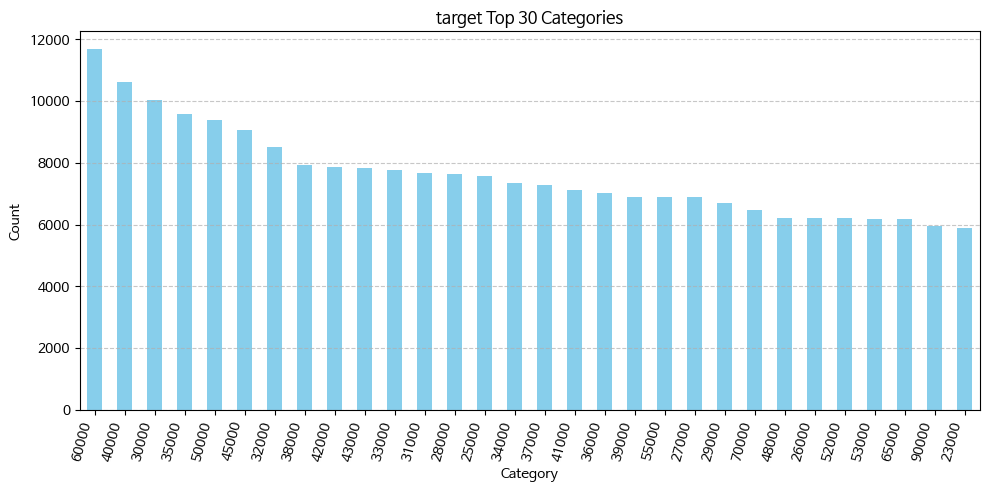

In [9]:
# 추가할 missing value 아무 의미 없는 값 (0, NULL 등 추가)
custom_missing_value = ['-']
for col in df_train.columns:
    feature_summary(df_train, col, custom_missing_value, True)